## Введение

Отчет интернет-магазина "В один клик" за прошлый период показал снижение активности покупателей. Т.к. магазин известный, то бизнес-статегия состоит не в привлечении новых клиентов, а *удержании постоянных покупателей.* Возможный выход - это персонализированные предложения.   

**Цель проекта - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.**

В ходе работы выделены следующие **задачи**:
 1) Промаркировать уровень финансовой активности постоянных покупателей: "снизилась" и "прежний уровень"
 
 2) Собрать данные по клиентам по следующим группам:
 - признаки, описывающие коммуникацию сотрудников компании с клиентом
 - признаки, описывающие продуктовое поведение покупателя (какие товары покупает и как часто)
 - признаки, описывающие покупательское поведение клиента (сколько тратил в магазине)
 - признаки, описывающие поведение на сайте (как много страниц просматривает и сколько времени проводит)

В ходе работы нужно **построить модель**, предсказывающую **вероятность снижения покупательской активности клиента в следующие три месяца**.

Исследование должно содержать **данные** о прибыльности клиента: **какой доход каждый покупатель приносил компании за последние три месяца**.

На основе модели и данных о прибыльности клиентов, нужно **выделить сегменты покупателей и разработать для них персонализированные предложения**.

В нашем проекте даны 4 датасета:


**market_file.csv** - содержит данные о поведении покупателя на сайте, его продуктовом поведении и коммуникациях с ним.
- **id** - номер покупателя в базе данных
- **Покупательская активность** — класс покупательской активности (целевой признак): «снизилась» или «прежний уровень»
- **Тип сервиса** — уровень сервиса («премиум» и «стандарт»)
- **Разрешить сообщать** — согласие покупателя присылать дополнительные предложения о товаре
- **Маркет_актив_6_мес** — среднемесячное значение маркетинговых коммуникаций компании на покупателя за последние 6 месяцев. Показывает, какое число рассылок, звонков, показов рекламы приходилось на клиента.
- **Маркет_актив_тек_мес** — количество маркетинговых коммуникаций в текущем месяце.
- **Длительность** — показывает сколько дней прошло с момента регистрации покупателя на сайте.
- **Акционные_покупки** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- **Популярная_категория** — самая популярная категория товаров у покупателя за последние 6 месяцев.
- **Средний_просмотр_категорий_за_визит** — сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- **Неоплаченные_продукты_штук_квартал** — общее число неоплаченных товаров в корзине за последние 3 месяца.
- **Ошибка_сервиса** — число сбоев, которые коснулись покупателя во время посещения сайта.
- **Страниц_за_визит** — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


**market_money.csv** -  данные о выручке, которую получает магазин с покупателя (сколько покупатель всего потратил за период взаимодействия с сайтом).

- **id** — номер покупателя в базе данных.
- **Период** — название периода за который зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- **Выручка** — сумма выручки за период.

**market_time.csv** - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- **id** — номер покупателя в базе данных.
- **Период** — название периода, во время которого зафиксировано общее время.
- **минут** — значение времени, проведённого на сайте, в минутах.

**money.csv** - данные о среднемесячной прибыли покупателя за последние 3 месяца (какую прибыль получает магазин от продаж каждому покупателю)

- **id** — номер покупателя в базе данных.
- **Прибыль** — значение прибыли.

## Загрузка данных

In [1]:
!pip install phik -q
!pip install -U scikit-learn==1.1.3 -q
!pip install shap -q
# !pip install -U shap scikit-learn

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [3]:
import warnings
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from phik.report import correlation_report, plot_correlation_matrix
from scipy.stats import pointbiserialr
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder,
                                   PolynomialFeatures
                                  )

from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (make_scorer,
                             roc_auc_score,
                             f1_score)
from sklearn.inspection import permutation_importance
import shap

In [4]:
# Уберем предупреждения категории FutureWarning, чтобы не отвлекали
warnings.simplefilter(action='ignore', category=FutureWarning )

In [5]:
RANDOM_STATE = 42

In [6]:
try:
    market_file = pd.read_csv('C:/Users/79533/Desktop/yandex_practicum/work_project/supervised_learning/market_file.csv')
    market_money = pd.read_csv('C:/Users/79533/Desktop/yandex_practicum/work_project/supervised_learning/market_money.csv')
    market_time = pd.read_csv('C:/Users/79533/Desktop/yandex_practicum/work_project/supervised_learning/market_time.csv')
    money = pd.read_csv('C:/Users/79533/Desktop/yandex_practicum/work_project/supervised_learning/money.csv', sep=';',decimal = ',')
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';',decimal = ',')

In [7]:
market_file.head(2)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5

In [8]:
market_money.head(2)

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1

In [9]:
market_time.head(2)

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13

In [10]:
money.head(2)


id  Прибыль
0  215348     0.98
1  215349     4.16

Для корректного чтения указали при загрузке файла sep=';',decimal = ',' 

Приведем названия столбцов к змеиному регистру:

In [11]:
datas=[market_file,
     market_money,
     market_time,
     money
    ]

for data in datas:
    data.columns = [re.sub(r'(\W)', '_', i).replace(' ','_').lower() for i in data.columns]


In [12]:
market_file

id покупательская_активность тип_сервиса разрешить_сообщать  \
0     215348                 Снизилась     премиум                 да   
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась   стандартт                нет   
3     215351                 Снизилась   стандартт                 да   
4     215352                 Снизилась   стандартт                нет   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
0                    3.4                     5           121   
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      акционные_покупки            популярная_категория  \
0                  0.00                Товары для детей   
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
0                                       6                                   2   
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      ошибка_сервиса  страниц_за_визит  
0                  1                 5  
1                  2                 5  
2                  1                 5  
3                  6                 4  
4                  3                 2  
...              ...               ...  
1295               3                11  
1296               3                 9  
1297               5                 7  
1298               5                 7  
1299               3                12  

[1300 rows x 13 columns]

## Предобработка данных

Посмотрим общую информацию о датасетах

In [13]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

Пропусков нет, типы данных определены верно. Большая часть данных числовые. 13 столбцов, 1300 строк

In [14]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Пропусков нет, типы данных правильные. 3 столбца, 3900 строк

In [15]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Пропусков нет, типы данных правильные. 3 столбца, 2600 строк

In [16]:
money

id  прибыль
0     215348     0.98
1     215349     4.16
2     215350     3.13
3     215351     4.87
4     215352     4.21
...      ...      ...
1295  216643     4.44
1296  216644     6.11
1297  216645     3.29
1298  216646     4.03
1299  216647     3.28

[1300 rows x 2 columns]

In [17]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Пропусков нет. 2 столбца, 1300 строк.

**Проверим наличие дубликатов**

In [18]:
print(f'market_file содержит {market_file.duplicated().sum()} полных дубликатов')
print(f'в market_money {market_money.duplicated().sum()} полных дубликатов')
print(f'в market_time {market_time.duplicated().sum()} полных дубликатов')
print(f'в money {money.duplicated().sum()} полных дубликатов')

market_file содержит 0 полных дубликатов
в market_money 0 полных дубликатов
в market_time 0 полных дубликатов
в money 0 полных дубликатов


Явных дубликатов нет. Посмотрим внимательнее по столбцам и устраним разночтения (если они есть)

In [19]:
market_file_cat = market_file.select_dtypes(exclude='number').columns.tolist()
for col in market_file[market_file_cat]:
    print(col,':',market_file[col].unique())

покупательская_активность : ['Снизилась' 'Прежний уровень']
тип_сервиса : ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать : ['да' 'нет']
популярная_категория : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


устраним разночтения в столбце 'тип_сервиса' и приведем все к нижнему регистру:

In [20]:
market_file['тип_сервиса'] = (market_file['тип_сервиса']
    .str.replace('стандартт','стандарт'))
market_file['популярная_категория'] = (market_file['популярная_категория']
    .str.replace('Косметика и аксесуары','Косметика и аксессуары'))
market_file[market_file_cat] = market_file[market_file_cat].apply(lambda x: x.str.lower())

In [21]:
market_file[market_file_cat]

покупательская_активность тип_сервиса разрешить_сообщать  \
0                    снизилась     премиум                 да   
1                    снизилась     премиум                 да   
2                    снизилась    стандарт                нет   
3                    снизилась    стандарт                 да   
4                    снизилась    стандарт                нет   
...                        ...         ...                ...   
1295           прежний уровень    стандарт                 да   
1296           прежний уровень    стандарт                нет   
1297           прежний уровень    стандарт                 да   
1298           прежний уровень    стандарт                 да   
1299           прежний уровень     премиум                 да   

                популярная_категория  
0                   товары для детей  
1                   товары для детей  
2                  домашний текстиль  
3                   товары для детей  
4                   товары для детей  
...                              ...  
1295  техника для красоты и здоровья  
1296               домашний текстиль  
1297               домашний текстиль  
1298  техника для красоты и здоровья  
1299  техника для красоты и здоровья  

[1300 rows x 4 columns]

In [22]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Тут все ок

In [23]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [24]:
market_time['период'] = (market_time['период']
    .str.replace('предыдцщий_месяц','предыдущий_месяц'))

Заменили опечатку в market_time. В money все столбцы числовые

In [25]:
market_file[market_file.duplicated(subset='id')==True]

Empty DataFrame
Columns: [id, покупательская_активность, тип_сервиса, разрешить_сообщать, маркет_актив_6_мес, маркет_актив_тек_мес, длительность, акционные_покупки, популярная_категория, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, ошибка_сервиса, страниц_за_визит]
Index: []

In [26]:
market_money[market_money.duplicated(subset=['id','период'])==True]

Empty DataFrame
Columns: [id, период, выручка]
Index: []

Много повторов id, но они в разных периодах. Это не дубли

In [27]:
market_time[market_time.duplicated(subset=['id','период'])==True]

Empty DataFrame
Columns: [id, период, минут]
Index: []

In [28]:
money[money.duplicated(subset='id')==True]

Empty DataFrame
Columns: [id, прибыль]
Index: []

Неявных дубликатов тоже нет

## Исследовательский анализ данных

### Оценим количественные данные


#### Посмотрим описательную статистику и boxplot

**market_file**

In [29]:
market_file.drop('id', axis=1).describe().T

count        mean         std    min  \
маркет_актив_6_мес                   1300.0    4.253769    1.014814    0.9   
маркет_актив_тек_мес                 1300.0    4.011538    0.696868    3.0   
длительность                         1300.0  601.898462  249.856289  110.0   
акционные_покупки                    1300.0    0.319808    0.249843    0.0   
средний_просмотр_категорий_за_визит  1300.0    3.270000    1.355350    1.0   
неоплаченные_продукты_штук_квартал   1300.0    2.840000    1.971451    0.0   
ошибка_сервиса                       1300.0    4.185385    1.955298    0.0   
страниц_за_визит                     1300.0    8.176923    3.978126    1.0   

                                        25%     50%    75%      max  
маркет_актив_6_мес                     3.70    4.20    4.9     6.60  
маркет_актив_тек_мес                   4.00    4.00    4.0     5.00  
длительность                         405.50  606.00  806.0  1079.00  
акционные_покупки                      0.17    0.24    0.3     0.99  
средний_просмотр_категорий_за_визит    2.00    3.00    4.0     6.00  
неоплаченные_продукты_штук_квартал     1.00    3.00    4.0    10.00  
ошибка_сервиса                         3.00    4.00    6.0     9.00  
страниц_за_визит                       5.00    8.00   11.0    20.00

Можно обратить внимание на *'акционные_покупки'*. Есть значимые отличия медианного значения от среднего, и разброс (std) в диапазоне значений этого столбца.  
Минимальное значение у *'маркет_актив_6_мес'* существенно меньше первого квартиля
Это может указывать на выбросы. В целом распределение данных кажется равномерным, без эктремальных значений.

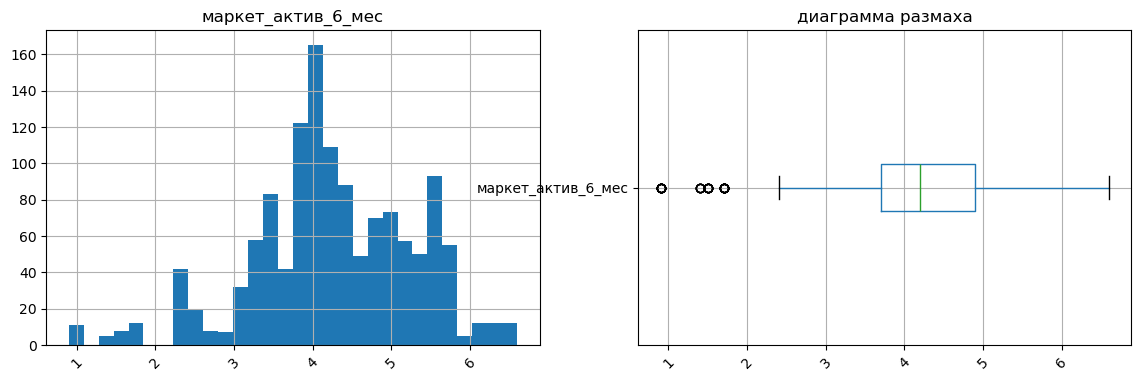

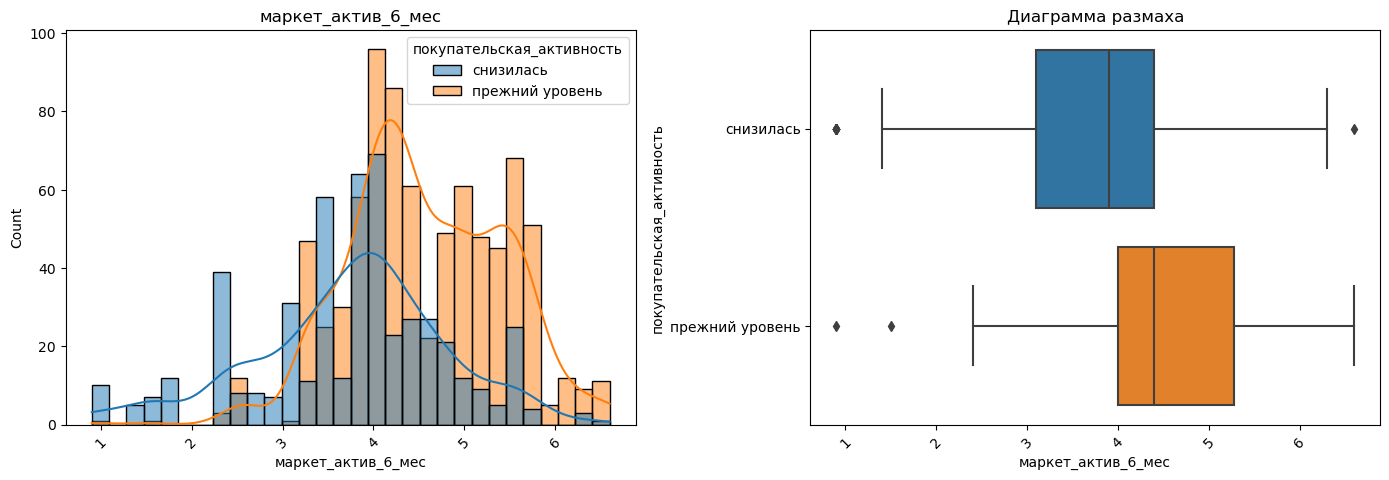

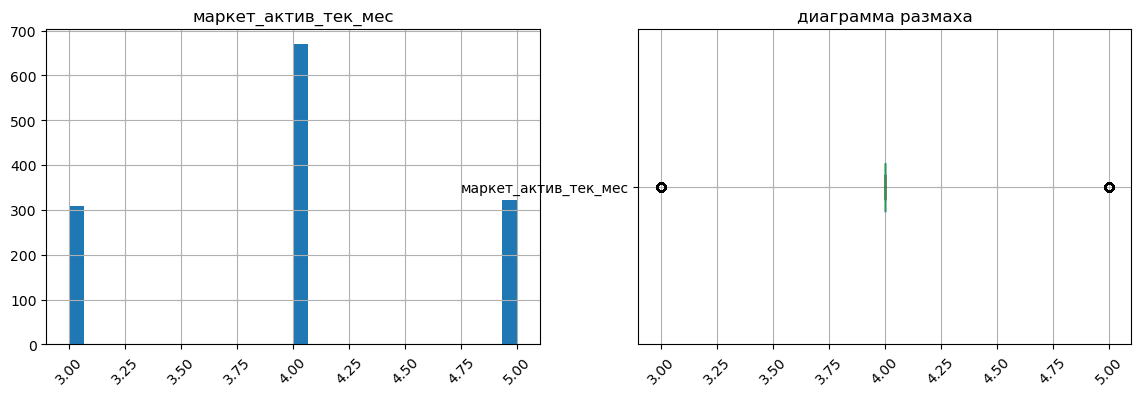

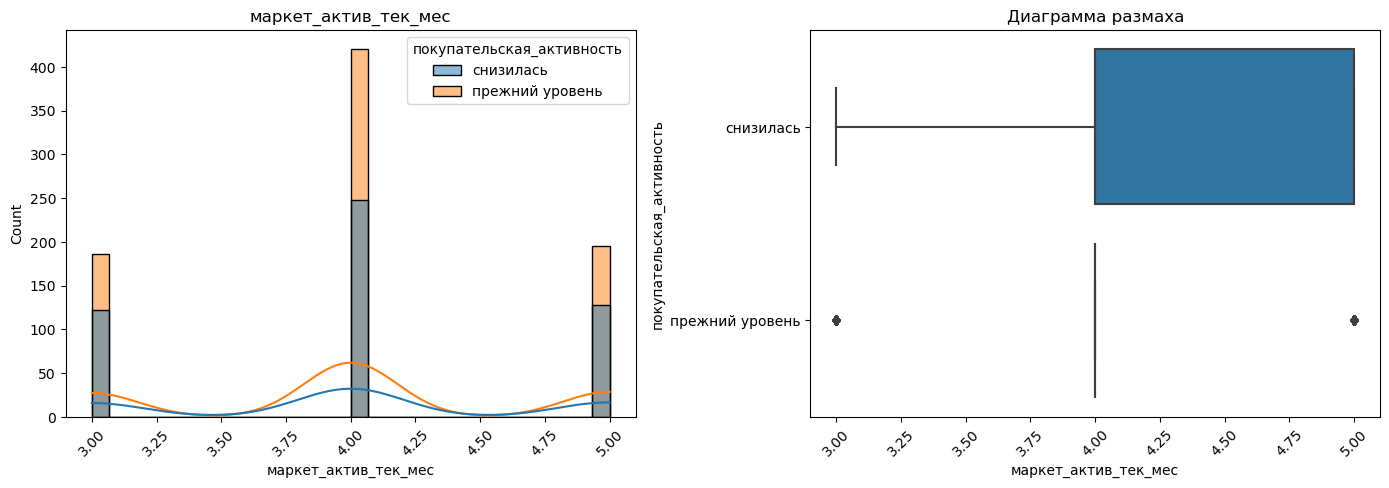

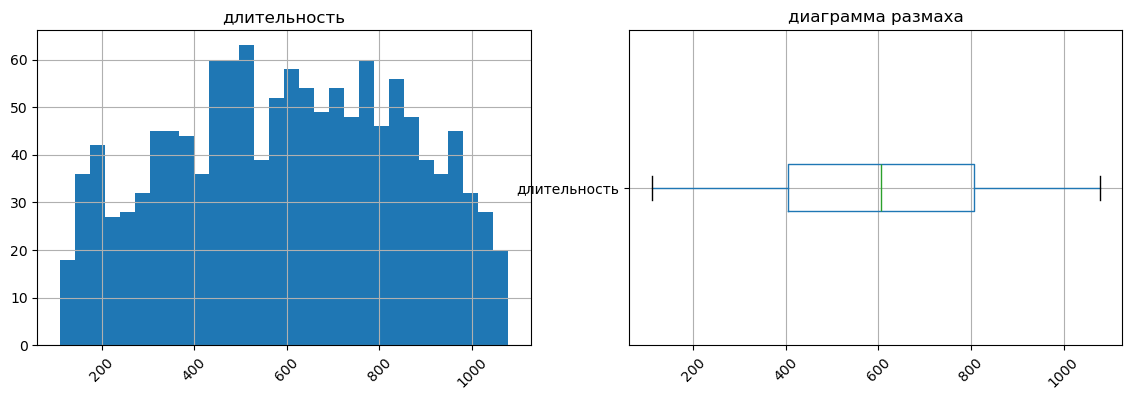

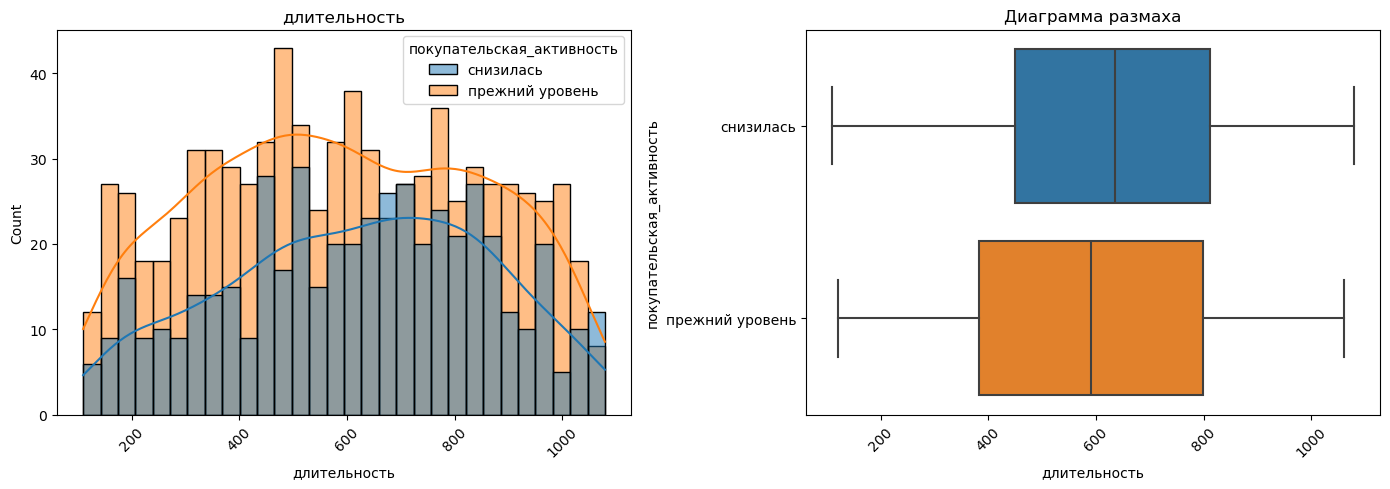

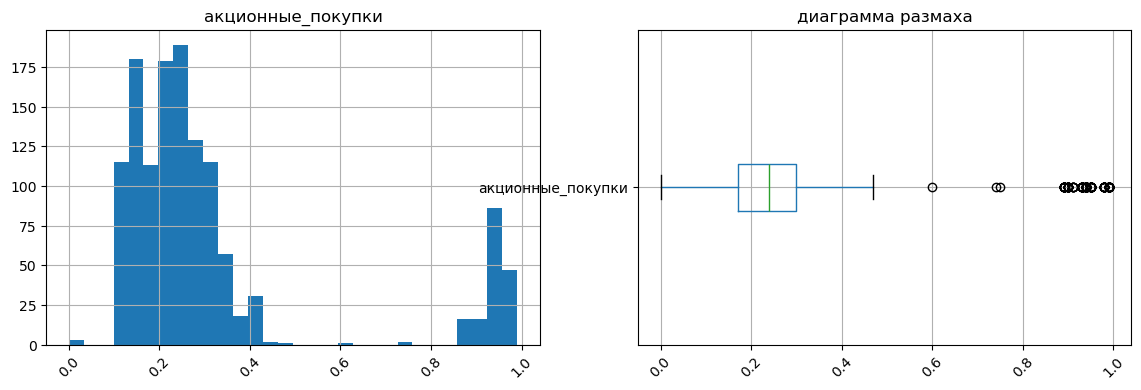

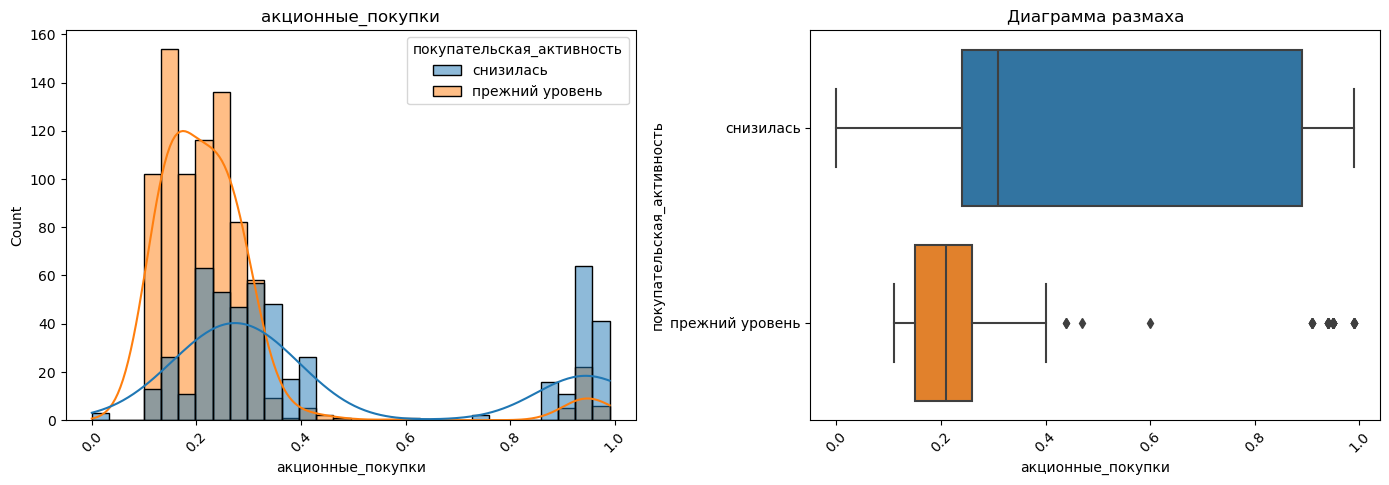

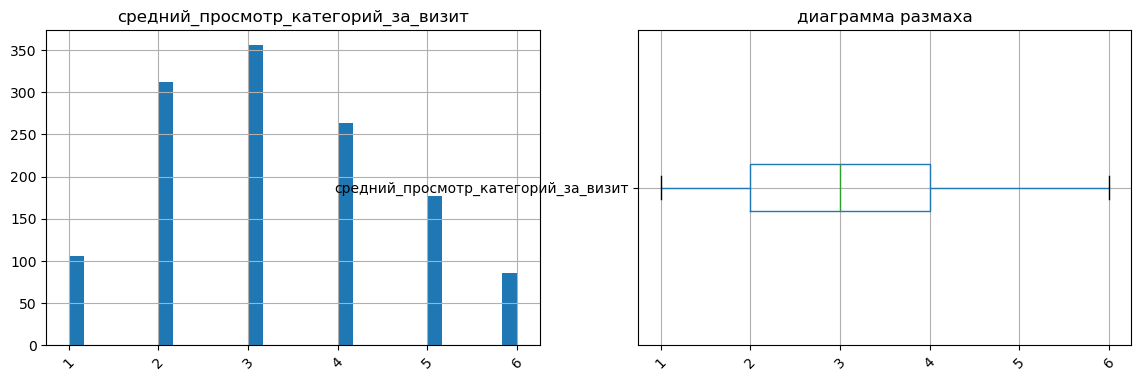

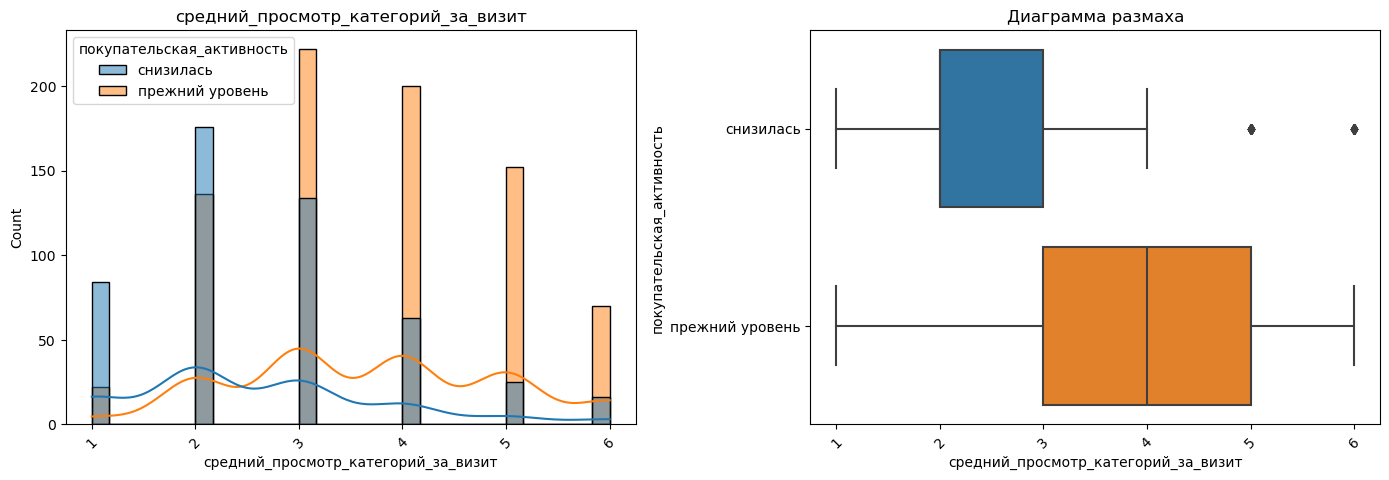

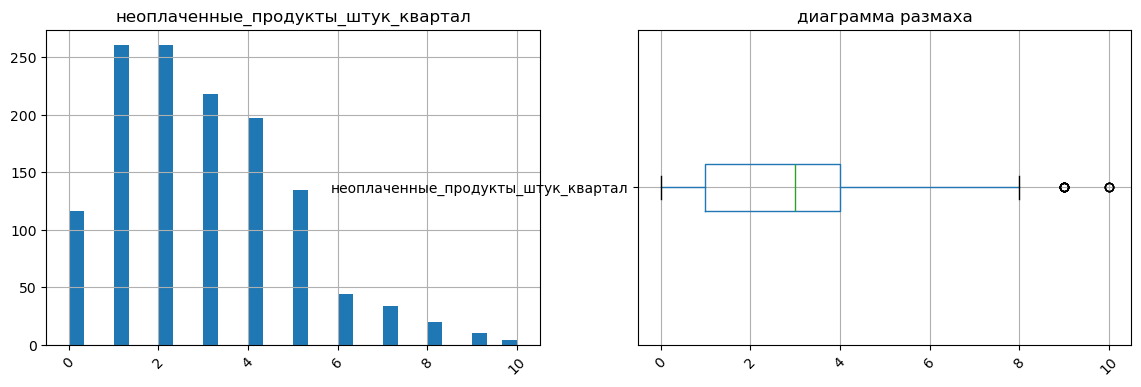

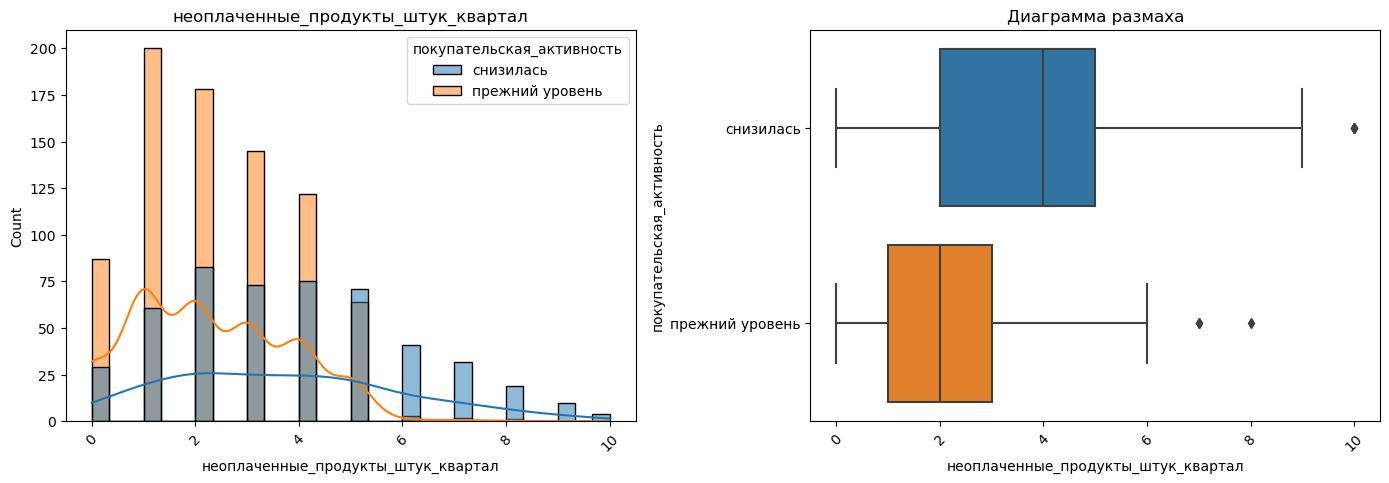

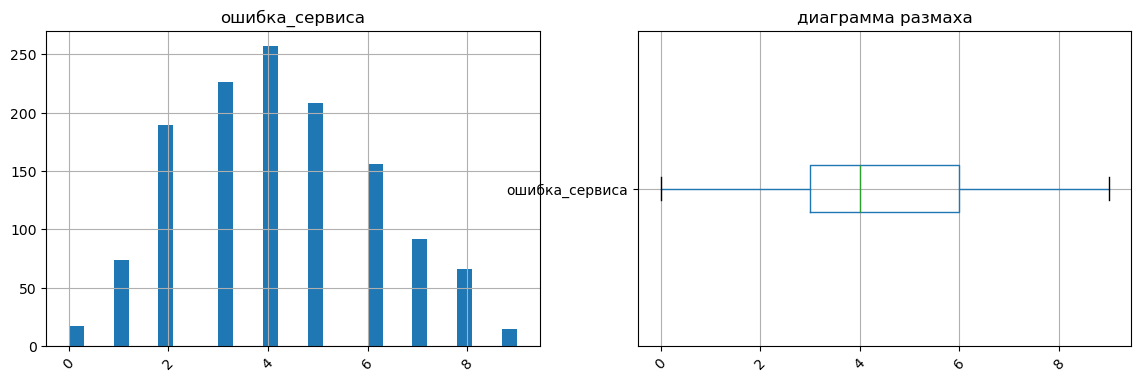

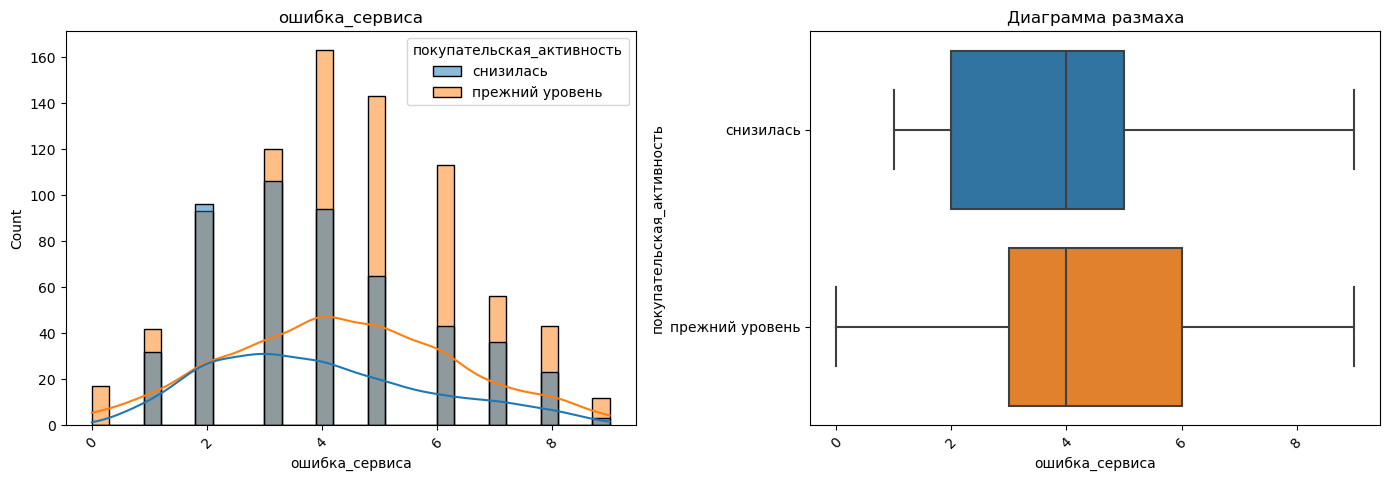

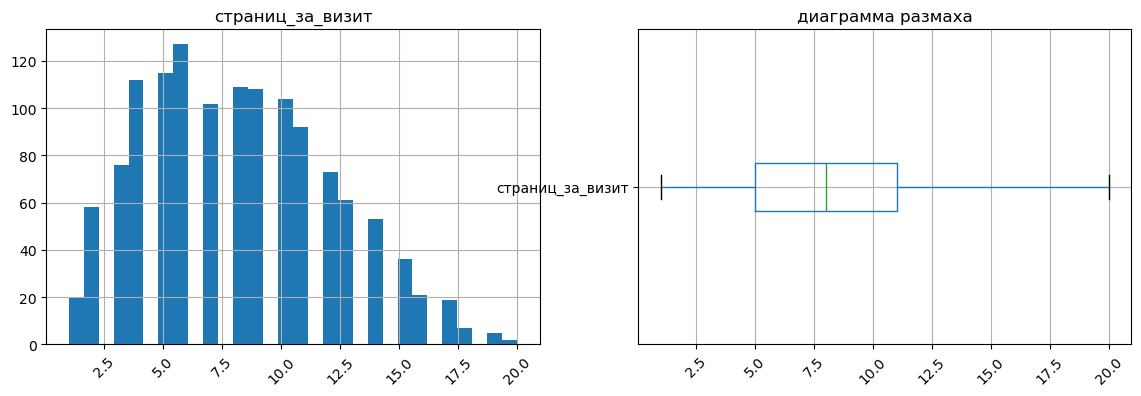

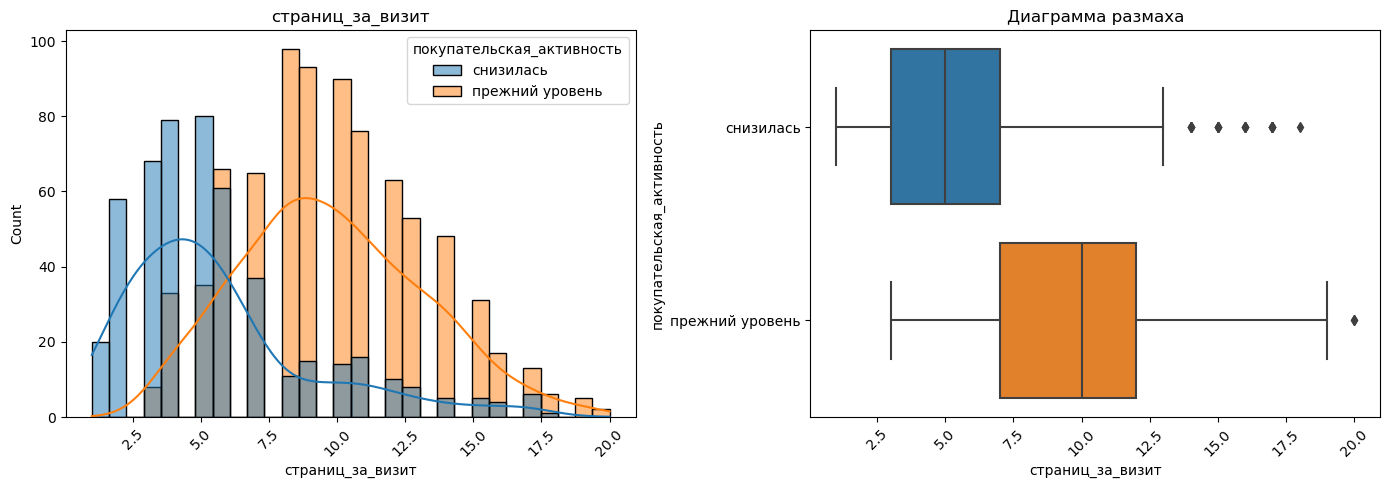

In [30]:
market_file_num = market_file.drop('id', axis=1).select_dtypes(include='number').columns.tolist()
for features in market_file[market_file_num]:

    plt.figure(figsize=(14,9))
    plt.subplot(2, 2, 1)
    market_file[features].hist(bins=30);
    plt.title(features)
    plt.xticks(rotation=45);

    plt.subplot(2, 2, 2)
    market_file[[features]].boxplot(vert=False);
    plt.xticks(rotation=45);
    plt.title('диаграмма размаха')
    plt.show()
    
    
    plt.figure(figsize=(14, 9))
    plt.subplot(2, 2, 1)
    sns.histplot(data=market_file, x=features, hue='покупательская_активность', bins=30, kde=True)
    plt.title(features)
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 2)
    sns.boxplot(data=market_file, x=features, y='покупательская_активность', orient='h')
    plt.title('Диаграмма размаха')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

1) **маркет_актив_6_мес**
- С основной массой клиентов взаимодействовали от 3 до 6 раз, в основном 4 раза. Есть небольшое количество покупателей, с кем взаимодействовали не много (1-2 раза) и очень много (больше 6 раз)
- Точки где коммуникации осуществлялись меньше 2 раз (но больше 0) тоже не выбросы. Возможно пользователь запретил рассылку
- Распределение группы в которой покупательская активность снизилась смещено левее, чем в которой активность осталась на прежнем уровне: число маркетинговых коммуникаций за 6 месяцев было меньше (есть покупатели с кем взаимодействовали всего 1-2 раза. С покупателями, активность которых осталась на прежнем уровне взаимодействовали не менее 2 раз

2) **маркет_актив_тек_мес**
-  Гистограмма показывает, что в текущем месяце с каждым клиентом взаимодействовали от 3 до 5 раз. В основном 4 раза
-  Основное число коммуникаций -  4. Т.к. вариабельность значений очень малеькая, то 3 и 5 указаны точками, но это не выбросы

3) **длительность**
- Большая часть клиентов зарегистрировалась 400-900 дней назад (один-три года)
- Выбросов нет

4) **акционные_покупки**
-  У большинства клиентов акционные покупки составляют 15-30% корзины. Однако есть категория клиентов, кто преимущественно берет товары по акции (85-99% корзины). Их можно выделить в отдельную группу и присылать им рассылку с акционными предложениями
- Т.к. признак акционные покупки как будто делится на 2 категории, точками изображена меньшая категория - покупатели с большим процентом покупок по акции. Но это не выбросы, доля покупок по акции не превышает единицу 
- У большей части категории покупателей с прежним уровнем активности акционные покупки составляют небольлшую часть корзины (до 30%). Среди 'покупателелей по акции' (чья корзина состоит более чем на 80% из товаров по акции) большую часть составляет клиенты, чья покупательская активность снизилась. Напрашивается  вывод, что этим клиентам нужны подходящие акционные предложения.   

5) **средний_просмотр_категорий_за_визит**
- Клиенты в осном просматривают от 2-4 категорий за визит. Чаще всего 3
- выбросов нет
- Покупатели, чья активность снизилась смотрят меньше категорий за визит

6) **неоплаченные_продукты_штук_квартал**
-  Распределение дискретное, скошено вправо. Основная масса значений лежит в диапазоне 1-5 товаров, чаще всего в корзине лежат 1-2 неоплаченных товара. Однако значение может доходить и до 10
- Это тоже не выбросы а распространенное поведение( накидать много всего в корзину для сравнения, а взять только то, что действительно нужно. 10 позиций это совсем не много)
- У покупателей с прежней активностью в корзине меньше неоплаченных товаров

7) **ошибка_сервиса**
-  Дискретное распределение с колоколообразной формой. Мода приходится на значение 4 - наиболее часто количество сбоев, с которым приходится сталкиваться покупателям (это очень много!). Распределение равномерно убывает в обе стороны (не симметрично). Очень мало клиентов, которые не сталкивались со сбоями. Есть клиенты которые сталкивались с 9 ошибками работы сайта. Необходимо улучшить работу сайта
- Выбросов нет
- неожиданно покупатели чья активность снизилась сталкивались с чуть меньшим количеством ошибок сервера ( но медианное значение одинаково)

8) **страниц_за_визит**
- Распределение скошено вправо. Мода - 6 страниц. В основном посматривают от 4 до 11 страниц
- Выбросов нет
- покупатели с прежней актвностью просматривают большее количество страниц за визит, чем те клиенты, чья активность снизилась


**market_money**

In [31]:
market_money.drop('id', axis=1).describe().T

count         mean          std  min      25%     50%     75%  \
выручка  3900.0  5025.696051  1777.704104  0.0  4590.15  4957.5  5363.0   

              max  
выручка  106862.2

Различие между медианным и средним значением не очень большое, но std довольно высокое. 
Т.к. мы анализируем выручку с клиента за период (месяц), высокое стандартное отклонение указывает, что в выборке есть как низкие, так и высокие значения, далеко удаленные от среднего уровня. Однако максимальное значение сильно выбивается, вполне вероятно, что это выброс.

Также большое значение std свидетельствует о высокой вариативности данных, что может быть показателем наличия различных подгрупп. В нашем случае столбец содержит три периода, посмотрим описательную статистику по ним:

In [32]:
group_comparison = market_money.drop('id', axis=1).groupby('период').describe()

In [33]:
group_comparison

выручка                                             \
                      count         mean          std     min      25%   
период                                                                   
предыдущий_месяц     1300.0  4936.920385   739.597997     0.0  4496.75   
препредыдущий_месяц  1300.0  4825.206923   405.979663     0.0  4583.00   
текущий_месяц        1300.0  5314.960846  2939.708156  2758.7  4706.05   

                                                  
                         50%       75%       max  
период                                            
предыдущий_месяц     5005.00  5405.625    6869.5  
препредыдущий_месяц  4809.00  5053.500    5663.0  
текущий_месяц        5179.95  5761.725  106862.2

1) В 'текущем месяце' каждый клиент хоть что-то купил.

2)В 'текущем месяце' высокое std и большое различие медианы со средним значением, выделяющийся максимум. Уточним, выброс ли это

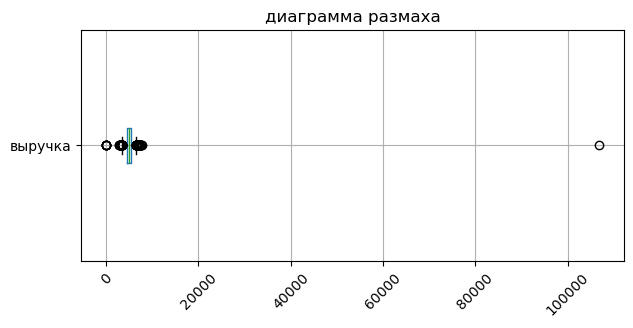

In [34]:
plt.figure(figsize=(7,3))
market_money.drop(['id'], axis=1).boxplot(vert=False);
plt.xticks(rotation=45);
plt.title('диаграмма размаха')
plt.show()

Очень похоже на выброс. Предположим, что выручка у нас указана в тысячах рублей, значение в 106 млн кажется очень большим. Найдем этого клиента в таблице и посмотрим какая от него прибыль:

In [35]:
market_money.query('выручка > 100000')

id         период   выручка
98  215380  текущий_месяц  106862.2

Мы знаем его id. Посмотрим прибыль от этого клиента

In [36]:
money.query('id == 215380')

id  прибыль
32  215380     3.88

Прибыль обычная, никаких сверхдоходов. Заменим значение выручки медианным

In [37]:
market_money.loc[market_money['выручка']> 100000,'выручка']=market_money['выручка'].median()
market_money.query('выручка > 100000')

Empty DataFrame
Columns: [id, период, выручка]
Index: []

**market_time**

In [38]:
market_time.drop('id', axis=1).describe().T

count       mean       std  min   25%   50%   75%   max
минут  2600.0  13.336154  4.080198  4.0  10.0  13.0  16.0  23.0

Выбивающихся значений у **времени**, проведенного на сайте не видно. Аналогично проанализируем периоды:

In [39]:
group_compar_time = market_time.drop('id', axis=1).groupby('период').describe()
group_compar_time

минут                                                  
                   count       mean       std  min   25%   50%   75%   max
период                                                                    
предыдущий_месяц  1300.0  13.467692  3.932029  5.0  11.0  13.0  17.0  23.0
текущий_месяц     1300.0  13.204615  4.220589  4.0  10.0  13.0  16.0  23.0

В обоих периодах распределение времени очень близко. В текущем месяце какая-то часть клиентов проводила незначительно меньше времени на сайте. Это может быть связано с тем, что интерфейс сайта покупателям уже знаком, и найти нужное можно быстрее

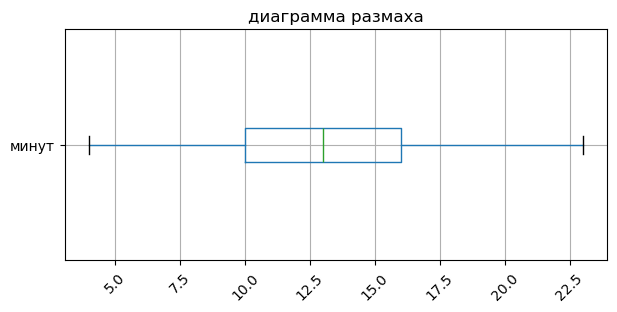

In [40]:
plt.figure(figsize=(7,3))
market_time.drop(['id'], axis=1).boxplot(vert=False);
plt.xticks(rotation=45);
plt.title('диаграмма размаха')
plt.show()

**money**

In [41]:
money.drop('id', axis=1).describe().T

count      mean       std   min  25%    50%   75%   max
прибыль  1300.0  3.996631  1.013722  0.86  3.3  4.045  4.67  7.43

Со среднемесячной прибылью за 3 месяца тоже кажется все неплохо.
Минимальное значение довольно сильно отличается от первого квартиля, причины отклонения схожи с таблицей с выручкой: какие-то покупатели тратят много, какие-то не очень (это может зависеть от доходов покупателя и их вкусовых предпотений). 


#### Построим гистограммы распределения признаков

**market_money, выручка**

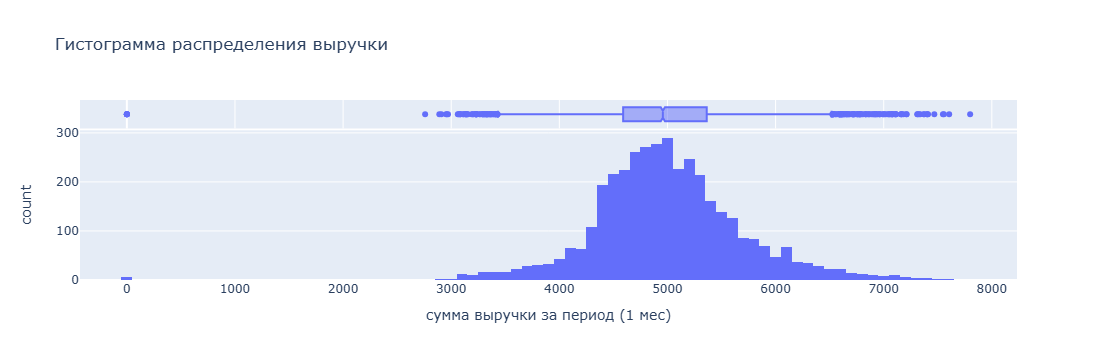

In [42]:
fig_market_money = px.histogram(
    market_money,
    x='выручка',
    nbins=100,
    marginal='box',
    title='Гистограмма распределения выручки',
    labels={'выручка':'сумма выручки за период (1 мес)'})

fig_market_money.show()

Клиентов, кто ничего не купил или купил на сумму меньше 50 довольно мало. Пик распределения 5000. Основной диапазон значений выручки с клиента 4350-5650

In [43]:
# разобьем столбец 'период' на отдельные столбцы. Исходный датасет сохраним неизменным
market_money_ind = market_money.set_index('id') 
market_money_1 = market_money_ind[market_money_ind['период']=='препредыдущий_месяц'].drop('период', axis=1)
market_money_1.columns= ['препредыдущий_месяц_выручка']
market_money_1['предыдущий_месяц_выручка'] = market_money_ind[market_money_ind['период']=='предыдущий_месяц']['выручка']
market_money_1['текущий_месяц_выручка'] = market_money_ind[market_money_ind['период']=='текущий_месяц']['выручка']
market_money_1.head(3)
 

препредыдущий_месяц_выручка  предыдущий_месяц_выручка  \
id                                                              
215348                          0.0                       0.0   
215349                       4472.0                    5216.0   
215350                       4826.0                    5457.5   

        текущий_месяц_выручка  
id                             
215348                 3293.1  
215349                 4971.6  
215350                 5058.4

**Построим совмещенную гистограмму для сравнения выручки в разные периоды**

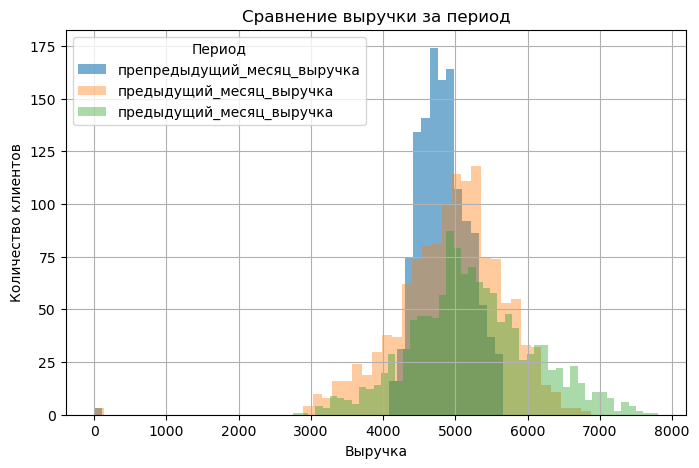

In [44]:
plt.figure(figsize=(8,5))
market_money_1['препредыдущий_месяц_выручка'].plot(kind='hist',bins=50, label='препредыдущий_месяц_выручка',alpha=0.6);

market_money_1['предыдущий_месяц_выручка'].plot(kind='hist',bins=50, label='предыдущий_месяц_выручка',alpha=0.4);

market_money_1['текущий_месяц_выручка'].plot(kind='hist',bins=50, label='предыдущий_месяц_выручка',alpha=0.4);

plt.grid(True)
plt.title('Сравнение выручки за период')
plt.legend(title='Период');
plt.xlabel('Выручка');
plt.ylabel('Количество клиентов');

В препрердыдущем периоде большая часть выручки от клиентов была состредоточена в более узком диапазоне: 4000-5800, каждый последующий период увеличивал ширину диапазона и пиковое значение гистограммы становилось меньше. Т.е. вариабельность стоимости покупки становиась шире: теперь диапазон выручки от клиентов колеблется в пределах 3000-7000( в предыдущем месяце) и 2900-8000 в текущем. По этому графику мы не можем утверждать что суммарная выручка за период уменьшилась или увеличилась

In [45]:
print('суммарная выручка за препредыдущий месяц', market_money_1['препредыдущий_месяц_выручка'].sum())
print('суммарная выручка за препредыдущий месяц', market_money_1['предыдущий_месяц_выручка'].sum())
print('суммарная выручка за текущий месяц', market_money_1['текущий_месяц_выручка'].sum())

суммарная выручка за препредыдущий месяц 6272769.0
суммарная выручка за препредыдущий месяц 6417996.5
суммарная выручка за текущий месяц 6807544.4


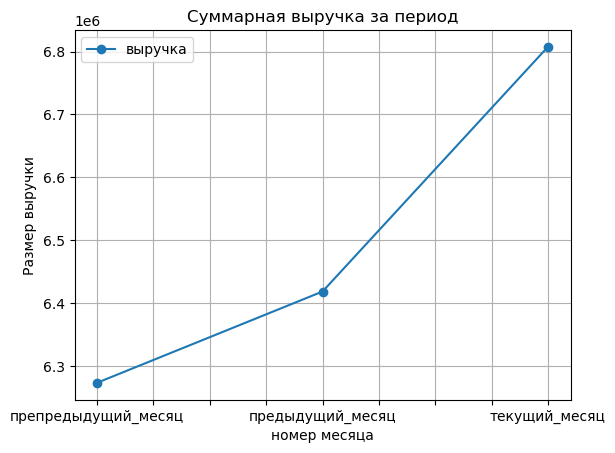

In [46]:
(market_money.pivot_table(index='период', values = ['выручка'], aggfunc ='sum')
    .reindex(['препредыдущий_месяц', 'предыдущий_месяц','текущий_месяц'])
    .plot(title='Суммарная выручка за период', grid= True, xlabel='номер месяца',
    ylabel='Размер выручки',style='o-')
    );

с каждым месяцем суммарная выручка увеличивается. Это хорошо, однако т.к. данные прдставлены только за 3 месяца это может быть сезонный подъем (например люди готовятся к новому году). Желательно предоставить данные за больший период

**market_time**, исследование времени, проведенного на сайте, за период времени

In [47]:
# разобьем столбец 'период' на отдельные столбцы.  Исходный датасет сохраним неизменным
market_time_ind = market_time.set_index('id')
market_time_1 = market_time_ind[market_time_ind['период']=='предыдущий_месяц']
market_time_1 = market_time_1.drop('период', axis=1)
market_time_1.columns= ['предыдущий_месяц_время']
market_time_1['текущий_месяц_время'] = market_time_ind[market_time_ind['период']=='текущий_месяц']['минут']
market_time_1.head(2)

предыдущий_месяц_время  текущий_месяц_время
id                                                 
215348                      13                   14
215349                      12                   10

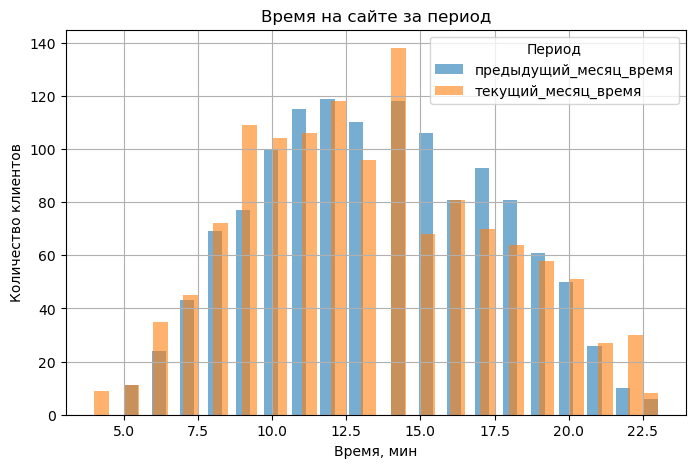

In [48]:
plt.figure(figsize=(8,5))
market_time_1['предыдущий_месяц_время'].plot(kind='hist',bins=38, label='предыдущий_месяц_время',alpha=0.6);

market_time_1['текущий_месяц_время'].plot(kind='hist',bins=38, label='текущий_месяц_время',alpha=0.6);

plt.grid(True)
plt.title('Время на сайте за период')
plt.legend(title='Период');
plt.xlabel('Время, мин');
plt.ylabel('Количество клиентов');

1) В текущем периоде появились клиенты, у которых буквально "приключение меньше 5 минут! Зашел и вышел"

2) В предыдущем периоде большинство клиентов проводили на сайте 10-13 мин. В текущем тенденция схожая, но появился явно выраженный пик на 14 минутах. Также увеличилось количество людей, находящихся на сайте около 22 мин

Сложно определить положительные это или отрицательные изменения, но увеличение очень малого и большого количества времени, проведенного на сайте можно связать с увеличением ошибок сервиса. Если сайт "зависал" и плохо работал то люди могли сразу выйти или наоборот, пытаться дождаться,когда сайт "развиснет" и заработает снова.

минут
период                 
предыдущий_месяц  17508
текущий_месяц     17166

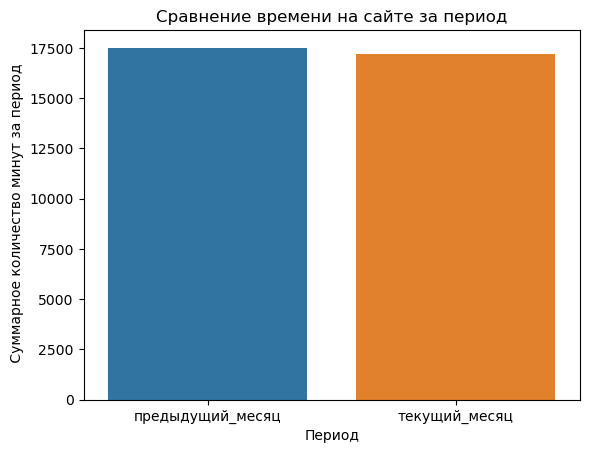

In [49]:
table_time = market_time.pivot_table(index='период', values = ['минут'], aggfunc ='sum')

plt.title('Сравнение времени на сайте за период')
sns.barplot(x=table_time.index, y = table_time['минут'])
plt.xlabel('Период');
plt.ylabel(' Суммарное количество минут за период');
table_time

Суммарное время, проведенное клиентами на сайте за период, практически не отличается (стало меньше на 342 минуты)

**money**, прибыль

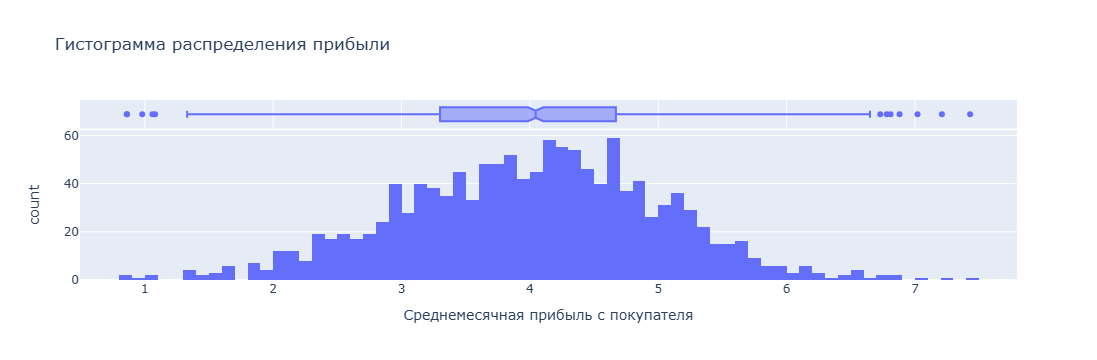

In [50]:
fig_money = px.histogram(
    money,
    x='прибыль',
    nbins=90,
    marginal='box',
    title='Гистограмма распределения прибыли',
    labels={'прибыль':'Среднемесячная прибыль с покупателя'})

fig_money.show()

Медианное значение прибыли 4,05. Основной диапазон прибыли, которую приносит покупатель 3.3 - 4.7. Есть выбивающиеся значения: прибыль меньше 1,4 и больше 6,7. Хвосты распредения плавно уменьшаются, их нельзя считать выбросами

### Рассмотрим категориальные признаки

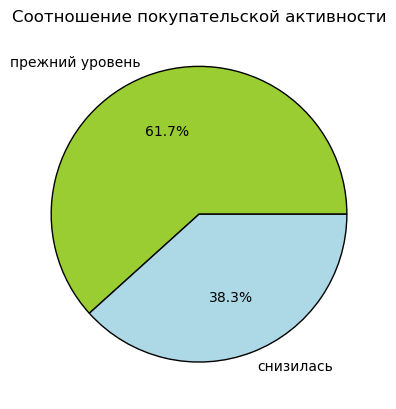

In [51]:
activity_count = market_file.pivot_table(index='покупательская_активность',values='id',aggfunc='count')
activity_count.columns=['count']

mycolors = ["yellowgreen", "lightblue"]
plt.pie(activity_count['count'], labels=activity_count.index,wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'black'},colors =  mycolors, autopct='%.1f%%')
plt.title('Cоотношение покупательской активности')
plt.show()

Покупательская активность снизилась в 38,3% случаев. Возможно для более точной оценки стоит добавить категорию, где покупательская активность повысилась
Покупательсская активность - целевой признак. В нашем случае виден дисбаланс классов. При дальнейшей оценке модели нужно будет подобрать подходящую метрику с учетом дисбаланса


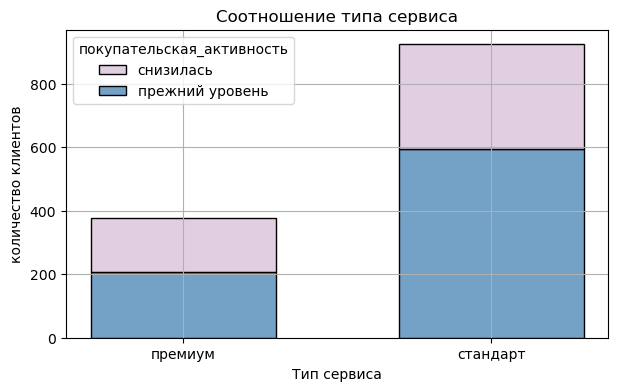

In [52]:
plt.figure(figsize=(7, 4))
my_colors = ['thistle','steelblue']
plt.grid(True)
plt.title('Соотношение типа сервиса')
sns.histplot(data=market_file, x='тип_сервиса', hue='покупательская_активность',multiple= "stack",binwidth=0.5,shrink=0.6, palette=my_colors);
plt.xlabel('Тип сервиса');
plt.ylabel('количество клиентов');
plt.show()

In [53]:
print('премиум', market_file.query('тип_сервиса=="премиум"')['тип_сервиса'].count())
print('стандарт',market_file.query('тип_сервиса=="стандарт"')['тип_сервиса'].count())

(market_file.query('тип_сервиса=="стандарт"')['тип_сервиса']
 .count()/market_file.query('тип_сервиса=="премиум"')
 ['тип_сервиса'].count()).round(2)

премиум 376
стандарт 924


2.46

In [54]:
print('покупательская активность снизилась в премиум',(market_file.query('тип_сервиса=="премиум" & покупательская_активность=="снизилась"')
 ['id'].count()/market_file.query('тип_сервиса=="премиум"')['id'].count()).round(2))

print('покупательская активность снизилась в стандарте',(market_file.query('тип_сервиса=="стандарт" & покупательская_активность=="снизилась"')
 ['id'].count()/market_file.query('тип_сервиса=="стандарт"')['id'].count()).round(2))
#market_file.query('тип_сервиса=="премиум" & покупательская_активность=="снизилась"')['id'].count()

покупательская активность снизилась в премиум 0.45
покупательская активность снизилась в стандарте 0.35


Клиентов с уровнем сервиса 'стандарт' значительно больше (в 2.46 раза), чем 'премиум'. Мы видим что покупательская активность в премиум сегменте снизилась сильнее, чем в стандарте

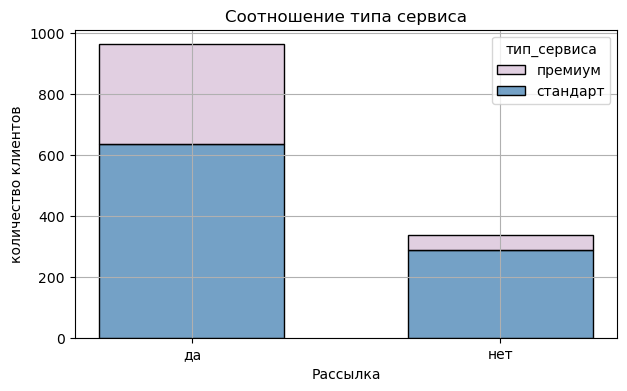

In [55]:
plt.figure(figsize=(7, 4))
my_colors = ['thistle','steelblue']
plt.grid(True)
plt.title('Соотношение типа сервиса')
sns.histplot(data=market_file, x='разрешить_сообщать', hue='тип_сервиса',multiple= "stack",binwidth=0.5,shrink=0.6, palette=my_colors);
plt.xlabel('Рассылка');
plt.ylabel('количество клиентов');
plt.show()

Большая часть клиентов не против рассылки предложений и среди них гораздо больше клиентов с типом сервиса премиум. Среди тех, кто отказался от рассылки клиентов с премиумом немного.

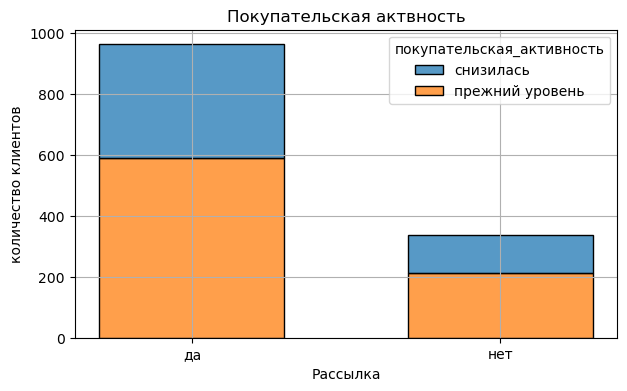

In [56]:
plt.figure(figsize=(7, 4))
plt.grid(True)
plt.title('Покупательская актвность')
sns.histplot(data=market_file, x='разрешить_сообщать', hue='покупательская_активность',multiple= "stack",binwidth=0.5,shrink=0.6);
plt.xlabel('Рассылка');
plt.ylabel('количество клиентов');
plt.show()

Соотношение клиентов, чья покупательская активность снизилась, одинаковое в категории где рассылка предложений разрешена (снизилась у 38%) и где нет (снизилась у 37,5%)

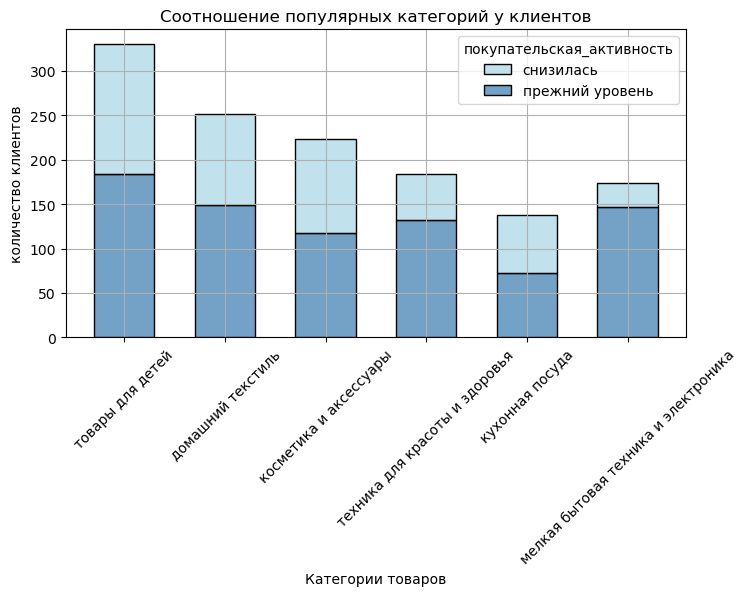

In [57]:
plt.figure(figsize=(8, 4))
my_colors = ['lightblue','steelblue']
plt.grid(True)
plt.title('Соотношение популярных категорий у клиентов')
sns.histplot(data=market_file, x='популярная_категория', hue='покупательская_активность',multiple= "stack",binwidth=0.5,shrink=0.6, palette=my_colors);
plt.xlabel('Категории товаров');
plt.ylabel('количество клиентов');
plt.xticks(rotation=45);
plt.show()

Меньше всего покупательская активность снизилась у клиентов с популярными категориями: 'мелкая бытовая техника и электроника', на втором месте 'техника для красоты и здоровья'. Больше всего снизилась у клиентов с популярными категориями 'товары для детей' и 'косметика и аксессуары'.
Однако, самая наиболее часто пользующаяся спросом категория это 'товары для детей'. Наименее популярный раздел это 'кухонная посуда'

## Объединение таблиц

Проверим id покупателей, которые есть в market_file, но нет в market money 

In [58]:
market_file['id'][~market_file['id'].isin(market_money['id'])] 

Series([], Name: id, dtype: int64)

Таких нет. Можно объединить эти таблицы по id. Сделаем id индексом у market_file.

In [59]:
market_file_ind = market_file.set_index('id')

Нам нужны все данные из первого и второго датасетов, поэтому у метода join возьмем атрибут how= outer

In [60]:
print('market_file_ind до объединения', market_file_ind.shape)
print('market_money_1 до объединения', market_money_1.shape)
market_full = market_file_ind.join(market_money_1, how='outer')
print('market_full после', market_full.shape)

market_file_ind до объединения (1300, 12)
market_money_1 до объединения (1300, 3)
market_full после (1300, 15)


In [61]:
market_full.head(2)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215348                 снизилась     премиум                 да   
215349                 снизилась     премиум                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215348                 3.4                     5           121   
215349                 4.4                     4           819   

        акционные_покупки популярная_категория  \
id                                               
215348               0.00     товары для детей   
215349               0.75     товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215348                                    6   
215349                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215348                                   2               1                 5   
215349                                   4               2                 5   

        препредыдущий_месяц_выручка  предыдущий_месяц_выручка  \
id                                                              
215348                          0.0                       0.0   
215349                       4472.0                    5216.0   

        текущий_месяц_выручка  
id                             
215348                 3293.1  
215349                 4971.6

In [62]:
#добавим третий датасет
print('market_full до объединения', market_full.shape)
print('market_time_1 до объединения', market_time_1.shape)
market_full = market_full.join(market_time_1, how='outer')
print('market_full после объединения', market_full.shape)

market_full до объединения (1300, 15)
market_time_1 до объединения (1300, 2)
market_full после объединения (1300, 17)


Найдем клиентов, которые не  приносили выручку хоть в одном месяце

In [63]:
bad_id = market_money[market_money['выручка']==0].id.unique()

In [64]:
market_full = market_full.drop(bad_id) 

In [65]:
# код ревьюера
market_full[market_full[['препредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка']].eq(0).any(axis=1)]

Empty DataFrame
Columns: [покупательская_активность, тип_сервиса, разрешить_сообщать, маркет_актив_6_мес, маркет_актив_тек_мес, длительность, акционные_покупки, популярная_категория, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, ошибка_сервиса, страниц_за_визит, препредыдущий_месяц_выручка, предыдущий_месяц_выручка, текущий_месяц_выручка, предыдущий_месяц_время, текущий_месяц_время]
Index: []

Тактика магазина - удержать постоянных клиентов, предсказав снижение их покупательской активности и своевременно сделав подходящие предложения. Если активности нет - то и удерживать нечего. (Хотя это спорный момент на мой взгляд)

## Корреляционный анализ

In [66]:
market_full.tail(3)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
216645           прежний уровень    стандарт                 да   
216646           прежний уровень    стандарт                 да   
216647           прежний уровень     премиум                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
216645                 4.1                     3           586   
216646                 6.3                     5           645   
216647                 4.0                     5           906   

        акционные_покупки            популярная_категория  \
id                                                          
216645               0.20               домашний текстиль   
216646               0.12  техника для красоты и здоровья   
216647               0.94  техника для красоты и здоровья   

        средний_просмотр_категорий_за_визит  \
id                                            
216645                                    3   
216646                                    3   
216647                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
216645                                   2               5                 7   
216646                                   3               5                 7   
216647                                   5               3                12   

        препредыдущий_месяц_выручка  предыдущий_месяц_выручка  \
id                                                              
216645                       5334.0                    5160.0   
216646                       4725.0                    4923.0   
216647                       5183.0                    4720.0   

        текущий_месяц_выручка  предыдущий_месяц_время  текущий_месяц_время  
id                                                                          
216645                 5139.2                      12                   18  
216646                 5224.6                      18                    7  
216647                 4448.3                      15                   10

переведем таргет в бинарный признак: 1-снизилась, 0-прежний уровень

In [67]:
bin_conditions = [
    market_full['покупательская_активность'] =='снизилась',
    market_full['покупательская_активность'] =='прежний уровень'
]
target = [1, 0]
market_full['target'] = np.select(bin_conditions, target, 'другой')
market_full['target']=market_full['target'].astype(int)

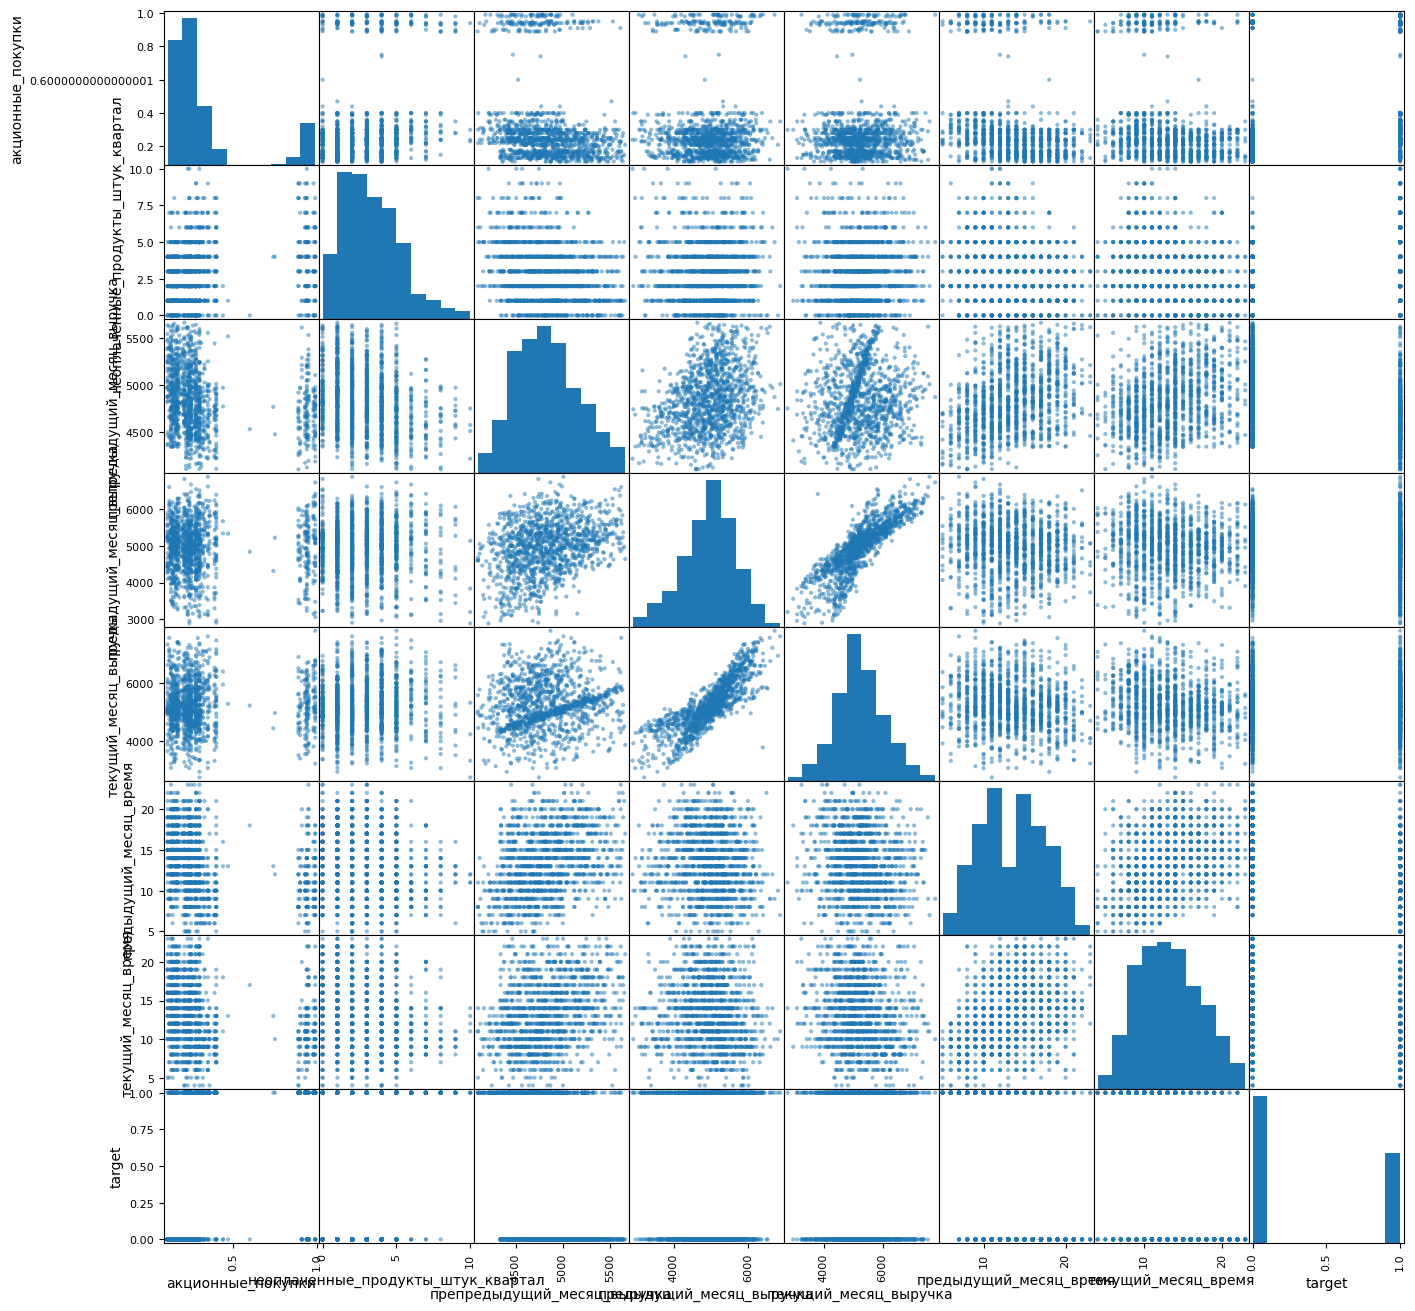

In [68]:
col_for_corr = [ 'акционные_покупки',
                 'неоплаченные_продукты_штук_квартал',
                 'препредыдущий_месяц_выручка',
                 'предыдущий_месяц_выручка',
                 'текущий_месяц_выручка',
                 'предыдущий_месяц_время',
                 'текущий_месяц_время',
                 'target']
pd.plotting.scatter_matrix(market_full[col_for_corr], figsize=(16, 16)); 

Мы видим, что в категории 'акционные покупки' есть разделение на два класса. Явных линейных зависимостей нет.

Интересное распределение у 'текущего','предыдущего' и 'препредыдущего месяца'. Корреляция улавливает взаимосвязь, скорее всего эти признаки мультиколлинеарны. 
Показатели выручки за разные месяцы часто связаны из-за автокорреляции — тенденции значений временного ряда быть зависимыми от предыдущих значений (если в одном месяце выручка высокая,то велика вероятность, что и в последующие месяцы выручка будет на высоком уровне). Если выручка имеет общий тренд (например, растет каждый месяц) или сезонные колебания, то данные за несколько соседних месяцев могут высоко коррелировать. 

Вопрос по признакам 'предыдущий_месяц_время','текущий_месяц_время'.

У нас данные распределены ненормально, зависимости в основном не линейные. Попробуем использовать корреляцию Спирмена для рассчета силы взаимосвязи

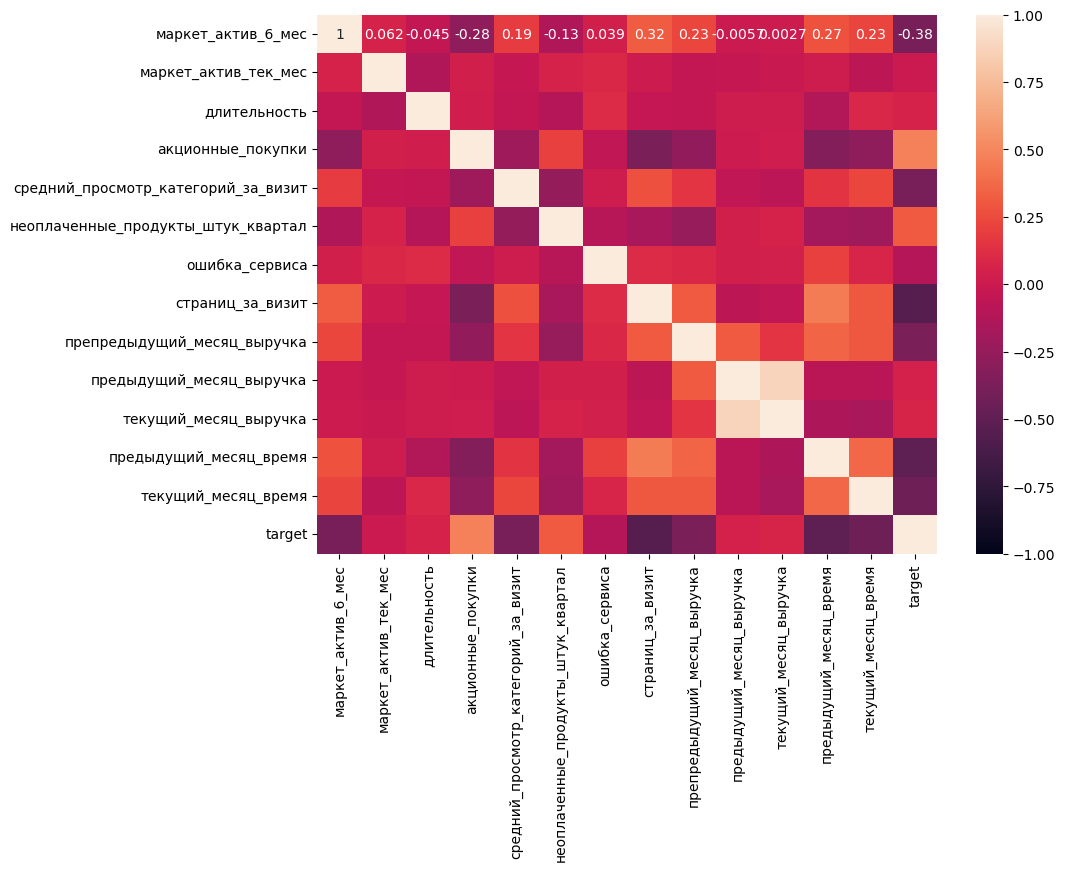

In [69]:
col_for_corr_1 = market_full.select_dtypes(include='number').columns.tolist()

fig, ax = plt.subplots(figsize=(10,7))
_ = sns.heatmap(market_full[col_for_corr_1].corr(method='spearman'),
                vmin=-1, vmax=1, annot=True, ax=ax)

Пары которые нас интересуют на предмет мультиколлинеарности:

выручка **'текущего' и 'предыдущего' -  0,87  - похоже на мультиколлинеарность**. Уберем предыдущий месяц   

выручка 'предыдущего' и 'препредыдущего месяца' - 0,31

выручка 'текущего' и 'препредыдущего месяца' 0.15

'предыдущий_месяц_время' и 'текущий_месяц_время' 0,36

'маркет_актив_6_мес' и 'маркет_актив_тек_мес' - 0,06


Попробуем посчитать точечно-бисериальную корреляцию для нашего таргета.Скорее всего она не очень подойдет т.к. ищет линейные зависимости и по сути, является вариантом корреляции Пирсона, адаптированным для случая, когда одна переменная бинарна. Посмотрим коэффициенты предполагаемых признаков с мультиколлинеарностью.

In [70]:
correlation_results = {}

for column in market_full[col_for_corr_1].drop('предыдущий_месяц_выручка',axis=1):  # Пропускаем 'target', так как он бинарный
    corr, p_value = pointbiserialr(market_full['target'], market_full[column])
    correlation_results[column] = {'Correlation': corr, 'p-value': p_value.round(3)}

# Преобразуем результаты в DataFrame для удобного отображения
correlation_df = pd.DataFrame(correlation_results).T
print(correlation_df.sort_values(by='Correlation'))

                                     Correlation  p-value
страниц_за_визит                       -0.515540    0.000
предыдущий_месяц_время                 -0.504768    0.000
текущий_месяц_время                    -0.420453    0.000
маркет_актив_6_мес                     -0.395745    0.000
средний_просмотр_категорий_за_визит    -0.374402    0.000
препредыдущий_месяц_выручка            -0.370841    0.000
ошибка_сервиса                         -0.098646    0.000
маркет_актив_тек_мес                   -0.003604    0.897
текущий_месяц_выручка                   0.061338    0.027
длительность                            0.062687    0.024
неоплаченные_продукты_штук_квартал      0.353695    0.000
акционные_покупки                       0.419158    0.000
target                                  1.000000    0.000



Correlation: показывает силу и направление связи между бинарной переменной и каждым числовым признаком.
p-value: указывает, является ли корреляция статистически значимой. Обычно значения p-значения меньше 0.05 считаются значимыми.
Получается что связь маркет_актив_тек_мес с таргетом нельзя считать статистически значимым

In [71]:
interval_cols = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
                 'акционные_покупки','средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал','ошибка_сервиса',
                 'страниц_за_визит', 'препредыдущий_месяц_выручка',
                 'текущий_месяц_выручка', 'предыдущий_месяц_время', 'текущий_месяц_время'
                ]

market_full_1=market_full.drop(['target','предыдущий_месяц_выручка'], axis=1)
phik_overview = market_full_1.phik_matrix(interval_cols =  interval_cols)

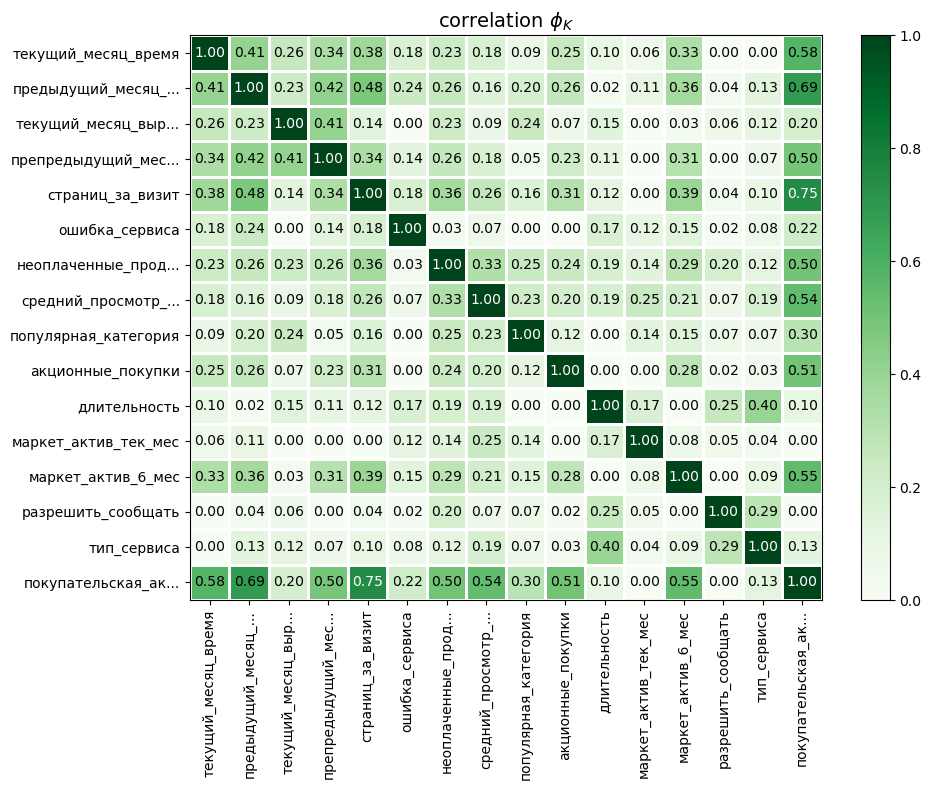

In [72]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

*Признаки с хорошей корреляцией:*
- 'предыдущий_месяц_время')0.68) и 'текущий_месяц_время'(0.58) с довольно высокой корреляцией. Оба эти признака похожи (хотя между ними корреляция не высокая), возможно модель будет 'метаться' между ними.
- страниц_за_визит (0.75)
- маркет_актив_6_мес )0.55)
- средний_просмотр_категорий_за_визит (0.54)
- неоплаченные_продукты_штук_квартал  (0.5)
- акционные_покупки (0.5)
- препредыдущий_месяц_выручка (0.49)

Попробуем разделить признак 'акционные покупки'на два класса

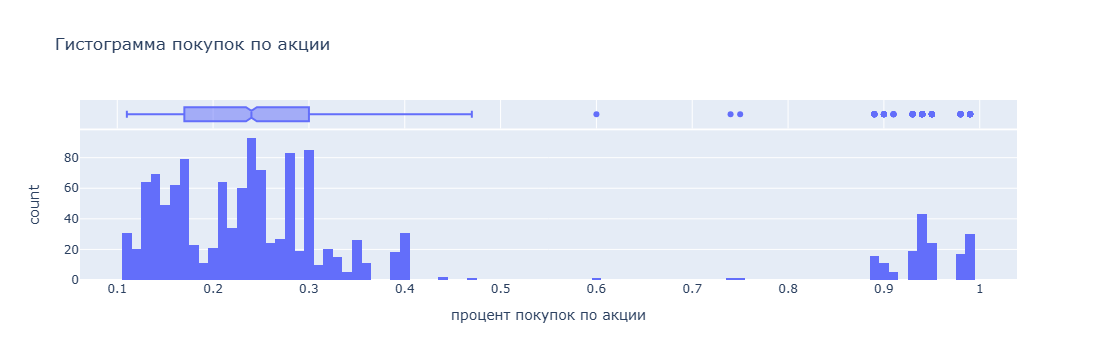

In [73]:
fig_market_money = px.histogram(
    market_full_1,
    x='акционные_покупки',
    nbins=100,
    marginal='box',
    title='Гистограмма покупок по акции',
    labels={'акционные_покупки':'процент покупок по акции'})

fig_market_money.show()

In [74]:
promotions_conditions = [
    market_full_1['акционные_покупки'] < 0.85,
    market_full_1['акционные_покупки'] >= 0.85
]
buyers_types = ['берет нужное', 'по акции']
market_full_1['buyers_types'] = np.select(promotions_conditions, buyers_types, 'другой')

In [75]:
market_full_1['buyers_types'].unique()

array(['берет нужное', 'по акции'], dtype=object)

In [76]:
phik_overview = market_full_1.phik_matrix(interval_cols =  interval_cols)
phik_overview['покупательская_активность'].sort_values(ascending=False).round(3)

покупательская_активность              1.000
страниц_за_визит                       0.749
предыдущий_месяц_время                 0.685
текущий_месяц_время                    0.576
маркет_актив_6_мес                     0.546
средний_просмотр_категорий_за_визит    0.539
акционные_покупки                      0.507
неоплаченные_продукты_штук_квартал     0.505
препредыдущий_месяц_выручка            0.495
buyers_types                           0.489
популярная_категория                   0.298
ошибка_сервиса                         0.224
текущий_месяц_выручка                  0.195
тип_сервиса                            0.132
длительность                           0.102
маркет_актив_тек_мес                   0.000
разрешить_сообщать                     0.000
Name: покупательская_активность, dtype: float64

При разделении признака 'акционные_покупки' на категории корреляция стала немного меньше. Оставим изначальный признак

In [77]:
market_full_1 = market_full_1.drop('buyers_types', axis=1)

А еще мы можем сделать мини-вывод, что в предпредыдущем месяце скорее всего были хорошие акции, и люди брали товары по ним. Поэтому гистограмма распределения выручки за этот месяяц более сконцентрированна около пикового значения

**Наш набор фичей, который остался:**

In [78]:
market_full_1.columns

Index(['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'препредыдущий_месяц_выручка',
       'текущий_месяц_выручка', 'предыдущий_месяц_время',
       'текущий_месяц_время'],
      dtype='object')

In [79]:
market_full_1.head(2)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 снизилась     премиум                 да   
215350                 снизилась    стандарт                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     товары для детей   
215350               0.14    домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   

        препредыдущий_месяц_выручка  текущий_месяц_выручка  \
id                                                           
215349                       4472.0                 4971.6   
215350                       4826.0                 5058.4   

        предыдущий_месяц_время  текущий_месяц_время  
id                                                   
215349                      12                   10  
215350                       8                   13

## Пайплайны

In [80]:
ohe_columns = ['популярная_категория','разрешить_сообщать']

ord_columns = ['тип_сервиса']

num_columns = ['маркет_актив_6_мес','маркет_актив_тек_мес','акционные_покупки',
                 'средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал',
                'ошибка_сервиса', 'страниц_за_визит', 'препредыдущий_месяц_выручка',
                'текущий_месяц_выручка', 'предыдущий_месяц_время', 'длительность','текущий_месяц_время']

In [81]:
market_full['покупательская_активность'].unique()

array(['снизилась', 'прежний уровень'], dtype=object)

In [82]:
# Разделим на выборки

X = market_full_1.drop('покупательская_активность', axis=1)
y = market_full_1['покупательская_активность']

#сделаем стратификация, т.к. классы несбалансированны
X_train, X_test, y_train, y_test = train_test_split(
        X,y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)



label_encoder = LabelEncoder()
label_encoder.fit(['прежний уровень', 'снизилась'])  # порядок определяет кодирование (прежний уровень - 0)
y_train = label_encoder.transform(y_train)

y_test = label_encoder.transform(y_test) 

У нас дисбаланс классов в задаче бинарной классификации. В качестве скоринга могут подойти roc-auc (для общей оценки как хорошо модель различает классы) или F1-score. Т.к. нам важно определить именно тех клиентов, у кого снизится покупательская активность, возможно F1 будет важнее.

In [83]:
!pip install xgboost
from xgboost import XGBClassifier

In [84]:
# создаём пайплайн для подготовки признаков из списка ohe_columns:
ohe_pipe = Pipeline(
    [        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns:
ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])


param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'models' : [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE),
        LogisticRegression(random_state=RANDOM_STATE),
        XGBClassifier(random_state=RANDOM_STATE)
    ]
} 

param_distributions = [  
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
# т.к. у нас есть потенциально неважные фичи попробуем L1 регуляризацию
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
            'models__C': range(1, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': range(100, 400, 50),  # подбираем количество деревьев
        'models__learning_rate': [0.01, 0.05, 0.1],   # подбираем скорость обучения
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    }
    
] 


def roc_auc_proba_score(y_true, y_proba):
    return roc_auc_score(y_true, y_proba)

roc_auc_proba_scorer = make_scorer(roc_auc_proba_score, needs_proba=True)


scoring = {
    'roc_auc': roc_auc_proba_scorer,
    'f1': make_scorer(f1_score)  # бинарная классификация, метрика F1
}

In [85]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring=scoring,
    refit='roc_auc',  # лучший параметр по 'roc_auc' на основе вероятностей
    random_state=RANDOM_STATE, 
    n_jobs=-1,
    n_iter=50  # Можно задать число итераций для улучшения
)

randomized_search.fit(X_train, y_train) 


print('Метрика roc_auc для модели:\n', randomized_search.cv_results_['mean_test_roc_auc'])
print('Метрика f1 для модели:\n', randomized_search.cv_results_['mean_test_f1'])

print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 



y_test_pred_proba = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]

print(f'Метрика ROC-AUC на тестовой выборке(на основе вероятностей): {roc_auc_score(y_test, y_test_pred_proba)}')

Метрика roc_auc для модели:
 [0.90952682 0.90122323 0.90872233 0.83684815 0.8416058  0.85232398
 0.90585217 0.90943984 0.89671766 0.82590987 0.90703264 0.80465314
 0.90999109 0.83342458 0.90766808 0.88172715 0.91023998 0.91023998
 0.90112431 0.8386513  0.89866082 0.9082759  0.90628435 0.84623367
 0.90911205 0.85792699 0.85112534 0.90633991 0.85465723 0.90999109
 0.85923945 0.82624413 0.90833805 0.80465314 0.90752694 0.85219457
 0.90741956 0.90426582 0.8432307  0.90971758 0.82629961 0.84375561
 0.85289181 0.90721251 0.85565285 0.85911723 0.90943984 0.85601635
 0.89794033 0.85927813]
Метрика f1 для модели:
 [0.84913503 0.81552062 0.82410438 0.78100908 0.78436043 0.79177454
 0.8173683  0.84573778 0.80583862 0.78439428 0.81981327 0.73815548
 0.82801569 0.76936172 0.84832145 0.79944056 0.84320126 0.84320126
 0.80721236 0.77331619 0.81010325 0.85046636 0.82399826 0.78326499
 0.81951443 0.72211155 0.78658874 0.84022399 0.7438274  0.82801569
 0.69457296 0.77980524 0.84337694 0.73815548 0.83931

Мы видим что у модели с лучшей 'roc_auc' метрика f1 тоже неплохая. Но на тестовой выборке скоринг сильно упал, скорее всего оверфит 

In [86]:
result = pd.DataFrame(randomized_search.cv_results_)

In [87]:
result[['rank_test_roc_auc', 'param_models', 'mean_test_roc_auc','params']
].sort_values('rank_test_roc_auc').head(3)

rank_test_roc_auc                                       param_models  \
17                  1  XGBClassifier(base_score=None, booster=None, c...   
16                  1  XGBClassifier(base_score=None, booster=None, c...   
29                  3  XGBClassifier(base_score=None, booster=None, c...   

    mean_test_roc_auc                                             params  
17           0.910240  {'preprocessor__num': MinMaxScaler(), 'models_...  
16           0.910240  {'preprocessor__num': StandardScaler(), 'model...  
29           0.909991  {'preprocessor__num': StandardScaler(), 'model...

In [88]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  u...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [89]:
# извлекаем лучшую модель из пайплайна
best_model = randomized_search.best_estimator_

## Анализ важности признаков

Наша лучшая модель XGBClassifier, у нее нет коэффициентов. Пропишем это:

In [90]:
if isinstance(best_model.named_steps['models'], LogisticRegression):
    coefficients = best_model.named_steps['models'].coef_
    print("Коэффициенты модели LogisticRegression:\n", coefficients)
else:
    print("Лучшая модель не является линейной и не имеет коэффициентов.")

Лучшая модель не является линейной и не имеет коэффициентов.


Как можно оценить важность признаков? Используем метод Permutation Importance

In [91]:
bestEstimator = best_model.named_steps['models']
X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)

In [92]:
permutation = permutation_importance(bestEstimator, X_test_transformed, y_test, random_state=RANDOM_STATE, scoring = 'roc_auc') 
permutation

{'importances_mean': array([ 7.54293051e-04, -1.20365912e-04,  3.07334296e-03,  3.20975766e-05,
         2.22044605e-17,  2.56780613e-04, -2.24683036e-04,  3.46653828e-03,
         8.82683357e-05,  1.10816883e-02,  1.49414219e-02,  7.39849141e-03,
         5.29610014e-04,  5.57374418e-02,  1.18680790e-02, -2.59187931e-03,
         2.95377949e-02,  1.30797625e-03,  2.96180388e-02]),
 'importances_std': array([1.74703427e-04, 2.83705176e-04, 1.55155349e-03, 9.29722251e-04,
        2.53753624e-05, 3.26544535e-04, 1.35704819e-04, 3.73290469e-03,
        6.72997475e-04, 6.00626841e-03, 4.17342561e-03, 3.69371501e-03,
        1.98308092e-03, 9.20210848e-03, 3.27798220e-03, 3.68122963e-03,
        5.74646358e-03, 3.03557645e-03, 1.10609048e-02]),
 'importances': array([[ 8.02439416e-04,  4.41341679e-04,  8.42561387e-04,
          7.22195474e-04,  9.62927299e-04],
        [-6.82073503e-04,  4.01219708e-05,  1.11022302e-16,
         -4.01219708e-05,  8.02439416e-05],
        [ 1.20365912e-03,  

Выглядит красиво, но плохочитаемо. Построим график:

In [93]:
# Извлекаем шаг ColumnTransformer из пайплайна
preprocessor = best_model.named_steps['preprocessor']

# Список названий всех обработанных признаков
feature_names = []

# Проходимся по каждому трансформеру в ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    # Проверяем, является ли трансформер пайплайном
    if isinstance(transformer, Pipeline):
        # Если это пайплайн, извлекаем последний шаг (например, OneHotEncoder или OrdinalEncoder)
        last_step = transformer.named_steps[next(reversed(transformer.named_steps))]
    else:
        last_step = transformer
    
    # Если трансформер поддерживает метод get_feature_names_out (например, OneHotEncoder)
    if hasattr(last_step, 'get_feature_names_out'):
        # Добавляем имена признаков с учётом one-hot кодирования
        feature_names.extend(last_step.get_feature_names_out(columns))
    else:
        # В случае StandardScaler или других трансформеров, которые не изменяют имена признаков
        feature_names.extend(columns)
        
# Выводим итоговый список имен признаков
print("Имена признаков после обработки:\n", feature_names)

Имена признаков после обработки:
 ['популярная_категория_косметика и аксессуары', 'популярная_категория_кухонная посуда', 'популярная_категория_мелкая бытовая техника и электроника', 'популярная_категория_техника для красоты и здоровья', 'популярная_категория_товары для детей', 'разрешить_сообщать_нет', 'тип_сервиса', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 'предыдущий_месяц_время', 'длительность', 'текущий_месяц_время']


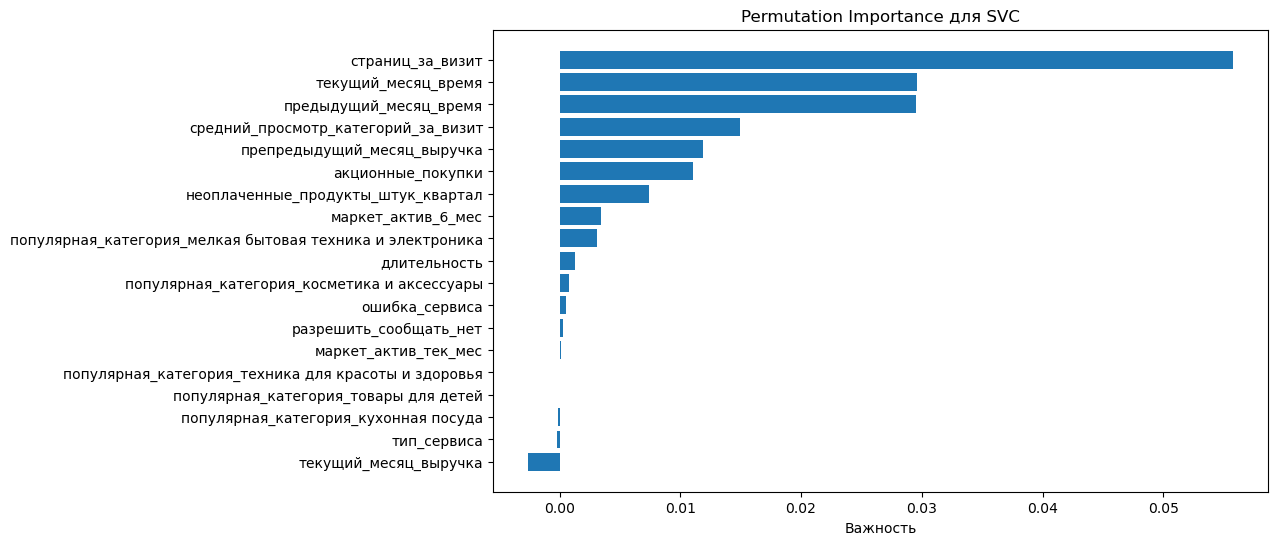

In [94]:
# Порядок признаков по важности
sorted_idx = np.argsort(permutation.importances_mean)[::-1]

# График важности признаков
plt.figure(figsize=(10,6))
plt.barh([feature_names[i] for i in sorted_idx], permutation.importances_mean[sorted_idx])
plt.xlabel("Важность")
plt.title("Permutation Importance для SVC")
plt.gca().invert_yaxis()
plt.show()

Нужно помнить о том, что permutation importance не учитывает влияние признака на другие признаки. 

Положительные значения указывают на важные признаки. Чем число больше- тем больше важность. 

Получается, **'средний просмотр категорий, страницы, препредыдущий месяц выручка, неоплаченные продукты, маркет_актив_6_мес, разрешить соощать и тип_сервиса'** - это важные признаки

Чем ближе к нулю, тем признаки менее значимы. Такие как: **'популярная категория кухонная посуда, популярная категория косметика и аксессуары, акционные покупки, товары для детей, длительность'**

Отрицательное значение признака может указывать на его шум или избыточность (его случайное перемешивание улучшает метрику) или на его корреляцию с другими признаками (при перемешивании можель начинает опираться на более полезные признаки)
Это указывает на то, что модель работает лучше без учёта этого признака.
**маркет_акитв_тек_мес,ошибка сервиса, текущий месяц выручка**

маркет_актив_тек_мес стоит удалить, 'популярная категория кухонная посуда, популярная категория косметика и аксессуары эти может тоже. 
А акционнные покупки все же стоит преобразовать в бинарный признак и попробовать в модели. 

In [95]:
m = best_model.named_steps['models']

In [96]:
X_train_preprocessed = best_model.named_steps['preprocessor'].transform(X_train)

explainer   = shap.SamplingExplainer(m.predict, X_train_preprocessed)
shap_values = explainer.shap_values(X_train_preprocessed)
shap_values_expl = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_train_preprocessed, feature_names = feature_names)

shap.plots.beeswarm(shap_values_expl, max_display=20)

В этом случае наименее важные признаки: 'популярная категория кухонная посуда, разрешить сообщать, косметика и аксессуары, тип сервиса, техника и электроника, текущий месяц выручка, ошибка сервиса, техника для красоты и здоровья, маркет актив тек мес'

Исходя из корреляции с таргетом, permutation importances и shap beeswarm уберем лишние признаки:

    - маркет актив тек мес
    - текущий месяц выручка
    - длительность
    - ошибка сервиса


- Если просмотрено мало страниц - это сдвигает предикт к 1 (активность снизилась),много- к 0 (осталась прежней)
- много времени на сайте - активность осталась прежней
- корзина состоит в основном из акционных покупок - смещает предсказание модели в сторону 1 ( активность снизилась)
- много неоплаченных товаров - предикт смещается к 1 ( активность снизилась)
- много просмотренных категорий - педсказание модели к нулю (прежний уровень активности), мало - активность снизилась
- много маркетинговой активности за 6 мес - покупательсская активность на прежнем уровне. Малое число коммуникаций - значение предикта смещается к единице (активность снизилась)
- больше значение выручки - активность на прежнем уровне

Остальные признаки влияют не сильно и их значение неоднозначно
- давно зарегистрированные пользователи сдигают к единице ( это странно, но признак не очень сильный)
- большое количество ошибок сервиса с которым столкнулся покупатель сдвигают предикт к 0 (прежняя активность)
- и еще более слабые признаки


In [97]:
X_new = market_full_1.drop(['покупательская_активность', 'ошибка_сервиса','маркет_актив_тек_мес',
                            'текущий_месяц_выручка',
                             'длительность',], axis=1)
y = market_full_1['покупательская_активность']

#сделаем стратификацию, т.к. классы несбалансированны
X_train_new, X_test_new, y_train, y_test = train_test_split(
        X_new,y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)


ohe_columns = ['разрешить_сообщать','популярная_категория']

ord_columns = ['тип_сервиса']

num_columns = ['маркет_актив_6_мес','акционные_покупки',
                 'средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал',
                 'страниц_за_визит', 'препредыдущий_месяц_выручка',
                 'предыдущий_месяц_время','текущий_месяц_время']

In [98]:
X_train_new.columns

Index(['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'страниц_за_визит',
       'препредыдущий_месяц_выручка', 'предыдущий_месяц_время',
       'текущий_месяц_время'],
      dtype='object')

In [99]:
label_encoder1 = LabelEncoder()
label_encoder1.fit(['прежний уровень', 'снизилась'])  # порядок определяет кодирование (прежний уровень - 0)
y_train = label_encoder1.transform(y_train)

y_test = label_encoder1.transform(y_test) 

In [100]:
# создаём пайплайн для подготовки признаков из списка ohe_columns:
ohe_pipe = Pipeline(
    [        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns:
ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',  XGBClassifier(random_state=RANDOM_STATE,learning_rate=0.05, n_estimators=100))
    ])

pipe_final.fit(X_train_new, y_train) 
pred= pipe_final.predict(X_test_new)


In [101]:
y_proba_train = pipe_final.predict_proba(X_train_new)[:, 1] 

roc_auc_train = roc_auc_score(y_train, y_proba_train )
print('Метрика roc_auc для train:\n', roc_auc_train)
y_proba_test = pipe_final.predict_proba(X_test_new)[:, 1] 

roc_auc_test = roc_auc_score(y_test,y_proba_test)
print('Метрика roc_auc для модели (test):\n', roc_auc_test)

Метрика roc_auc для train:
 0.9983585309300312
Метрика roc_auc для модели (test):
 0.9180308136735675


Метрика стала лучше,хотя модель все еще оверфитит

##  Сегментация покупателей

Сделаем большую и странную таблицу. Объединим наш train, y_train, X_test, pred и добавим датасет money

In [102]:
y_train = pd.Series(y_train)

In [103]:
X_train_1 = pd.concat([X_train_new, y_train], axis=1)
X_train_1.shape

(1944, 12)

In [104]:
X_test_1 = X_test_new
X_test_1['покупательская_активность'] = pred
X_test_1.shape

(325, 12)

In [105]:
combined = pd.concat([X_train_1, X_test_1])
combined.shape

(2269, 13)

In [106]:
money_1=money.set_index('id')
money_1.shape

(1300, 1)

In [107]:
combined = combined.join(money_1, how='outer')
print('combined после объединения', combined.shape)

combined после объединения (2272, 14)


Вернем недостающие признаки:

In [108]:
market_full.head(1)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 снизилась     премиум                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   

        препредыдущий_месяц_выручка  предыдущий_месяц_выручка  \
id                                                              
215349                       4472.0                    5216.0   

        текущий_месяц_выручка  предыдущий_месяц_время  текущий_месяц_время  \
id                                                                           
215349                 4971.6                      12                   10   

        target  
id              
215349       1

In [109]:
combined = combined.join(market_full[['маркет_актив_тек_мес','длительность','текущий_месяц_выручка']], how='outer')

In [110]:
combined = combined.drop(bad_id)
combined.shape

(2269, 17)

Выделим покупателей, чья активность снизилась в отдельную таблицу:

In [111]:
low_activity = combined.query('покупательская_активность == "снизилась"')

### Сегментируем по продуктовому поведению. 

**Покупатели по акции**

Анализ признака показал разделение покупателей на две группы: те, у кого более 80% покупок по акции и остальные. Выделим эту группу покупателей в отдельный сегмент. Но не все покупатели согласны на расслыку. Отберем согласных:


In [112]:
buyers_on_sale = low_activity.query('акционные_покупки > 0.8 & разрешить_сообщать == "да"')

print(buyers_on_sale.shape)
buyers_on_sale.head(3)

(0, 17)


Empty DataFrame
Columns: [тип_сервиса, разрешить_сообщать, маркет_актив_6_мес, акционные_покупки, популярная_категория, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, страниц_за_визит, препредыдущий_месяц_выручка, предыдущий_месяц_время, текущий_месяц_время, 0, покупательская_активность, прибыль, маркет_актив_тек_мес, длительность, текущий_месяц_выручка]
Index: []

В этой таблице **buyers_on_sale** находится категория покупателей, которым можно рассылать акционные предложения, для увеличения их покупательской активности

**Покупатели товаров с для детей**

Анализ признака *'популярная категория'* показал, что в категории *'бытовая техника и электроника'* и *'техника для здоровья и красоты'* активность снизилась меньше всего. Наибольшее снижение было отмечено в категориях *'товары для детей'* и *'косметика и аксессуары'*. Выделим сегменты постоянных покупателей в этих категориях.

In [113]:
for_kids = low_activity.query('популярная_категория =="товары для детей"')
for_kids.shape

(0, 17)

In [114]:
for_kids.query('тип_сервиса=="премиум"')['тип_сервиса'].count()

0

В детском сегменте у 144 клиентов (с разрешением на рассылку) отмечается снижение активности. Из них только 44 относятся к премиум-сегменту. Для привлечения этих клиентов можно делать рассылку и устраивать акции связанные с детскими товарами. Также можно организовывать детские активности (напрмер устроить день фэйс-пэйнтинга от имени магазина в каких-нибудь точках и давать скидочные купоны). Детский сегмент отличается от электроники тем, что постоянные клиенты часто соврешают покупки ( пачка памперсов стоит недешево и заканчивается за неделю. Это необходимый расходник. И если магазин может предложить удобную доставку в хорошие сроки и ценник чуть меньше, чем в других магазинах - то клиент будет делать заказ со стабильной периодичностью и в течение нескольких лет). Можно отметить важность доставки для этого сегмента покупателей - выходить куда-либо с детьми бывает очень неудобно. И если магазин может предложить доставку до дери, то это может дать большое преимущество перед другими конкурентами.

**Косметика и аксессуары**

In [115]:
cosmetics = low_activity.query('популярная_категория=="косметика и аксесуары"')

Эта категория больше относится к необязательным покупкам, в которую люди часто заходят чтобы 'пошопиться для радости'. Скорее всего именно в этом сегменте в корзине чаще остаются неоплаченные товары

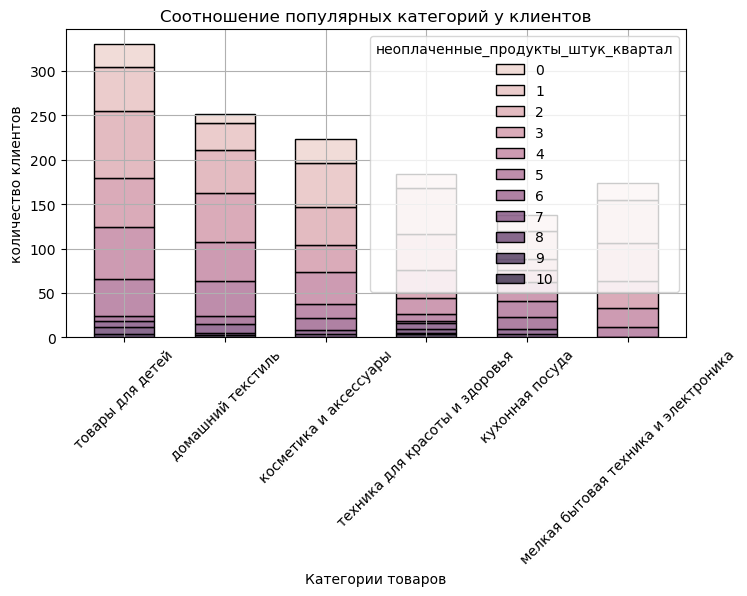

In [116]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.title('Соотношение популярных категорий у клиентов')
sns.histplot(data=market_file, x='популярная_категория', hue='неоплаченные_продукты_штук_квартал',multiple= "stack",binwidth=0.5,shrink=0.6);
plt.xlabel('Категории товаров');
plt.ylabel('количество клиентов');
plt.xticks(rotation=45);
plt.show()

На самом деле не сильно больше, чем в других категориях, но этот сегмент отличает то, что это не товары первой необходимости. Значит задача магазина сделать такое предложение, чтобы клиенту захотелось купить. Какие-нибудь акции "при покупке двух третий в подарок", что-то заставляющее покупателя вернуться. Рассылка с трендами (они постоянно меняются, а косметика и акссесуары это как раз про тренды)

**премиум-сегмент**

In [117]:
premium =low_activity.query('тип_сервиса=="премиум"')

Премиум сегменту можно предлагать дорогие товары из популярных категорий. Например электронику типо фена дайсон)

In [118]:
premium_technique =low_activity.query('тип_сервиса=="премиум" & популярная_категория=="техника для красоты и здоровья"')

## Выводы

В этойм исследовании был проанализирован массив данных, содержащий информацию о покупательской активновсти, продуктовом поведении клиентов, поведении покупателя на сайте, выручке и прибыли.

**Целью проекта** - являлось предсказать снижение покупательской активности клиента и  разработать решение, которое позволит персонализировать предложения.

В процессе работы были загружены данные и импортированы необходимые библиотеки, выполнена предобработка данных (приведены типы данных к необходимому, устранены разночтения, выбросы. Пропущенных значений не было). 

В ходе **исследовательского анализа данных** было обнаружено:
- В **текущем месяце** с каждым клиентом **взаимодействовали** от 3 до 5 раз. В основном 4 раза
- **За 6 месяцев тенденция взаимодействия** сохраняется. Однако появляются те, с кем взаимодействовали не много (1-2 раза) и очень много (больше 6 раз)
- Большая часть клиентов **зарегистрировалась** 400-900 дней назад (один-три года)
- У большинства клиентов **акционные покупки** составляют 15-30% корзины. Однако есть категория клиентов, кто преимущественно берет товары по акции (85-99% корзины). Их можно выделить в отдельную группу и присылать им рассылку с акционными предложениями
- Клиенты в осном просматривают от 2-4 **категорий за визит**. Чаще всего 3
- Чаще всего в **корзине лежат** 1-2 **неоплаченных товара**. Основной диапазон до 5,максимальное значение 10
- 4 - **наиболее частое количество сбоев**, с которым приходится сталкиваться покупателям.Мало клиентов, которые не сталкивались со сбоями. Есть клиенты которые сталкивались с 9 ошибками работы сайта. Необходимо улучшить работу сайта
- В основном **просматривают** от 4 до 11 **страниц**, наиболее частое значение 6
- Клиентов, кто ничего не купил или **купил на сумму** меньше 50 **за месяц** довольно мало. Пик распределения 5000. Основной диапазон значений выручки с клиента 4350-5650
- В **препрердыдущем периоде большая часть выручки** от клиентов была состредоточена в более узком диапазоне: 4000-5800. В следующих периодах вариабельность стоимости покупки становиась шире: диапазон выручки от клиентов колеблется в пределах 3000-7000( в **предыдущем месяце**) и 2900-8000 в **текущем**. Но **суммарная выручка** с каждым месяцем увеличивается.
- В **текущем периоде** появились "быстрые" клиенты, **время посещения сайта** которых менее 5 минут. 
- В **предыдущем периоде** большинство клиентов **проводили на сайте** 10-13 **мин**. В текущем тенденция схожая, но появился явно выраженный пик на 14 минутах. Также увеличилось количество людей, находящихся на сайте около 22 мин
Увеличение очень малого и большого количества времени, проведенного на сайте можно связать с увеличением ошибок сервиса. Если сайт "зависал" и плохо работал то люди могли сразу выйти или наоборот, пытаться дождаться,когда сайт "развиснет" и заработает снова. Для этой гипотезы нужно проверить увеличилось ли количество ошибок сайта в текущем месяце
- Медианное значение **прибыли** 4,05. Основной диапазон прибыли, которую приносит покупатель 3.3 - 4.7. 
- **Покупательская активность** снизилась в 38,3% случаев
- Клиентов с **уровнем сервиса** 'стандарт'(924) значительно больше (в 2.46 раза), чем 'премиум'(376). Покупательская активность в премиум сегменте снизилась сильнее, чем в стандарте
- Большая часть клиентов не против **рассылки предложений** и среди них гораздо больше клиентов с типом сервиса премиум. 
- Меньше всего покупательская активность снизилась у клиентов с **популярными категориями**: 'мелкая бытовая техника и электроника', на втором месте 'техника для красоты и здоровья'. Больше всего снизилась у клиентов с популярными категориями 'товары для детей' и 'косметика и аксессуары'. Однако, самая наиболее часто пользующаяся спросом категория это 'товары для детей'. Наименее популярный раздел это 'кухонная посуда'


**Корреляционный анализ показал**:
- мультиколлинеарность признаков выручка 'текущего' и 'предыдущего' периода.
Хорошая корреляция признаков с таргетом у :
- предыдущий_месяц_время(0.68)
- страниц_за_визит (0.75)
- маркет_актив_6_мес (0.55)
- средний_просмотр_категорий_за_визит (0.54)
- неоплаченные_продукты_штук_квартал (0.5)
- акционные_покупки (0.5)
- препредыдущий_месяц_выручка (0.49)

В процессе отбора модели был использован пайплан, в котором использовались разные кодировщики (**Label,One-hot,Ordinal encoder**), скейлеры (**Standard, MinMax**) и модели (**KNeighborsClassifier, DecisionTreeClassifier, SVC, LogisticRegression**) с подбором **гиперпараметров**. Для оценки качества модели использовали метрики **roc_auc и F1**

Лучшей моделью стала SVC(random_state=42). При настройке модели была исследована важность признаков несколькими методами: **Permutation Importance, shap.beeswarm**. Для улучшения качества модели были убраны избыточные признаки: 
 - маркет актив тек мес
 - текущий месяц выручка
 - длительность
 - ошибка сервиса

 **Точность модели** на тестовой выборке составила  0.92 по метрике 'roc-auc'
 
 
 **На основе данных была выполнена сегментация покупателей:**
 - выделен сегмент покупателей по акции **buyers_on_sale**
 
Категория покупателей, которым можно рассылать предложения c популярными акциями, для увеличения их покупательской активности

 - покупателей товаров для детей **for_kids**
 
 
В детском сегменте у 144 клиентов (с разрешением на рассылку) отмечается снижение активности. Из них только 44 относятся к премиум-сегменту. Для привлечения этих клиентов можно делать рассылку и устраивать акции связанные с детскими товарами. Также можно организовывать детские активности от имени магазина в каких-нибудь точках и давать скидочные купоны. Детский сегмент отличается от других тем, что в нем много товаров первой необходимости. Постоянные клиенты часто соврешают бытовые покупки. Можно отметить важность доставки для этого сегмента покупателей - выходить куда-либо с детьми бывает очень неудобно. Если магазин может предложить доставку до двери, то это может дать большое преимущество перед другими конкурентами.

 
 - косметики и аксессуаров **cosmetics**
 
 Эта категория больше относится к необязательным покупкам, в которую люди часто заходят чтобы 'пошопиться для радости'. Этот сегмент больше подвержен влияюнию моды и трендам. Можно сделать рассылку постоянным покупателям с самыми трендовыми товарами со скидкой. 
 
 
 - и премиум сегмент с любимой категорией "техника для красоты и здоровья" **premium_technique**
 
 В премиум сегменте совершаются большее число дорогих покупок. Можно рассылать акционные предложения дорогих товаров не первой необходимости, например в категории электроники для красоты и здоровья 

**Рекомендации**:
1) Необходимо улучшить работу сайта! Большинство клиентов сталкиваются с 2-5 сбоями во время посещения сайта. Это очень много

2) Данные предоставлены только за 3 месяца это может быть сезонный подъем (например люди готовятся к новому году). Желательно предоставить данные за больший период

3) Если сайт стал глючить чаще, это может быть причиной снижения активности клиентов. Для того, чтобы проверить увеличилось ли количество ошибок  в текущем периоде, нужно прислать данные немного в другом формате: не количество ошибок сервиса на клиента, а так, чтобы их можно было сопоставить с временными периодами

4) Возможно для более точной оценки стоит добавить в таргет категорию, где покупательская активность повысилась (не только "понизилась" и "осталась прежней")

5) Возможно в предпредыдущем месяце были хорошие акции, и люди брали товары по ним. Можно выяснить какие товары по акции были самыми популярными и проводить их с определенной периодичностью